# Quantum Generative Adversarial Network (QGAN) for Time Series Data

This notebook implements a Quantum GAN using PennyLane to analyze and generate time series data from Optical Density (OD) measurements. We'll build this implementation step by step, explaining each component along the way.

## Setup and Imports


In [1]:
# Install required packages
%pip install pennylane torch torchvision pandas numpy matplotlib seaborn scipy statsmodels fastdtw dtaidistance



[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, wasserstein_distance, probplot, entropy
from scipy.spatial.distance import euclidean
from scipy.special import lambertw
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import time
import numpy as np 
from fastdtw import fastdtw
from dtaidistance import dtw_visualisation as dtwvis
import random
from dtaidistance import dtw

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PennyLane imports
import pennylane as qml

# Set random seeds for reproducibility ### check source code for seed usage
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Data Loading and Preprocessing

First, we'll load our Optical Density (OD) time series data and perform initial visualization and preprocessing steps.


Data shape (total measurements): torch.Size([778])


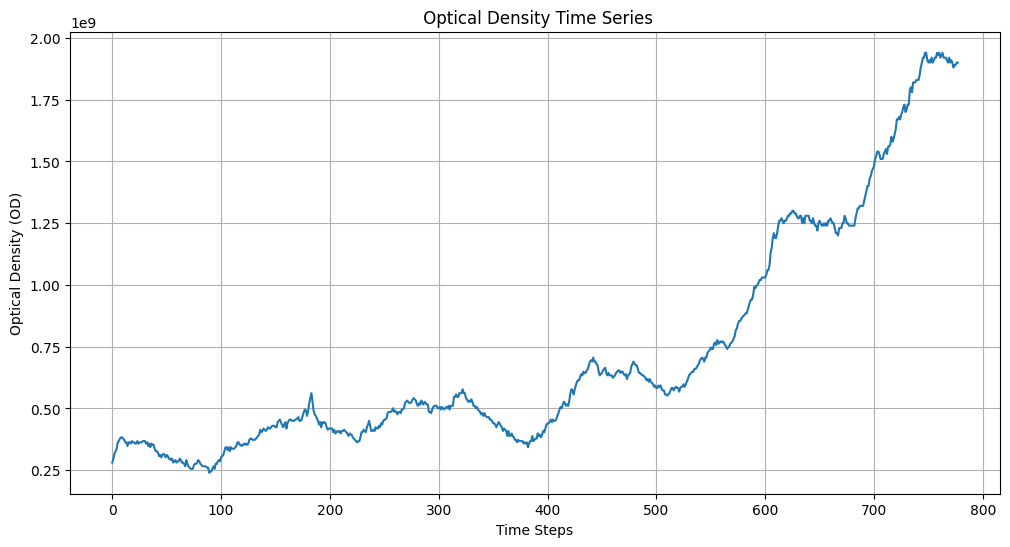


Basic data statistics:
count    7.780000e+02
mean     7.219640e+08
std      4.573705e+08
min      2.400000e+08
25%      4.090000e+08
50%      5.270000e+08
75%      8.850000e+08
max      1.940000e+09
Name: value, dtype: float64


In [3]:
# Load and preprocess the data
data = pd.read_csv('/Users/shawngibford/dev/Pennylane_QGAN/qGAN/data.csv', header=None, names=['value'])

# Convert string values to float, replacing any non-numeric values with NaN
data['value'] = pd.to_numeric(data['value'], errors='coerce')

# Fill missing values with rolling mean
data['value'] = data['value'].fillna(data['value'].rolling(window=10, min_periods=10).mean())

# Drop any remaining NaN values
data = data.dropna()

# Convert to tensor
OD = torch.tensor(data['value'].values, dtype=torch.float32)
print('Data shape (total measurements):', OD.shape)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(OD.numpy())
plt.title(' Optical Density Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Optical Density (OD)')
plt.grid(True)
plt.show()

# Display some basic statistics
print('\nBasic data statistics:')
print(data['value'].describe())


## Returns Analysis

Let's calculate and visualize both direct returns and logarithmic returns of our time series.


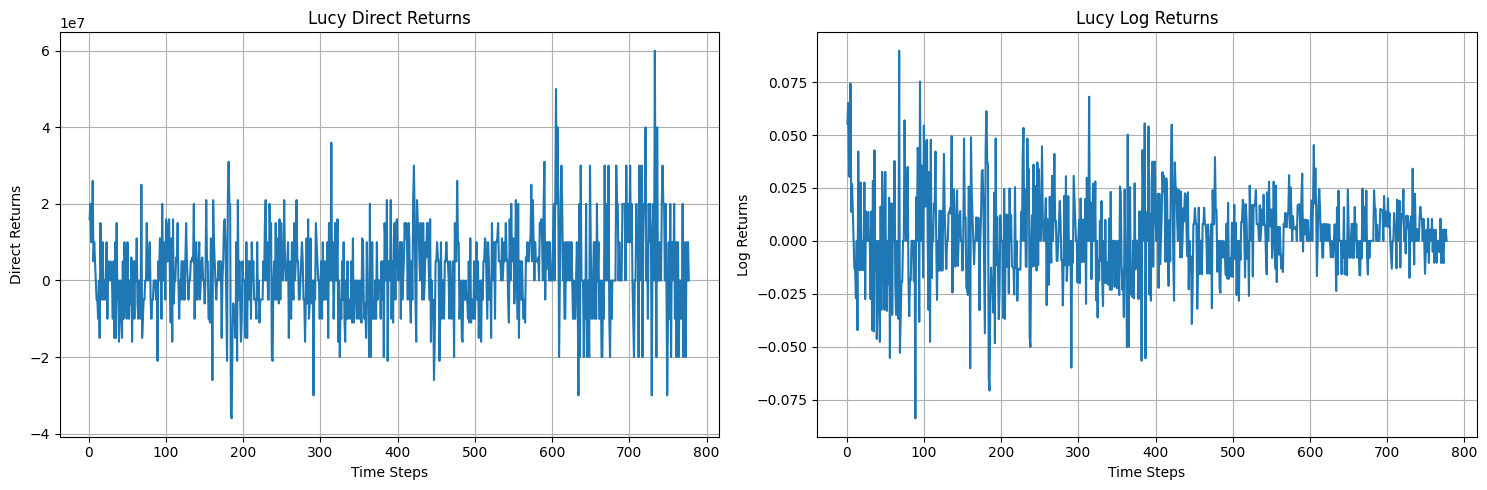


Direct Returns Statistics:
Mean: 2083655.1250
Std: 11912895.0000
Min: -36000000.0000
Max: 60000000.0000
Skewness: 0.3014
Kurtosis: 1.0530

Log Returns Statistics:
Mean: 0.0025
Std: 0.0211
Min: -0.0839
Max: 0.0898
Skewness: 0.0066
Kurtosis: 1.3363


In [4]:
# Create time index for plotting
time_index = np.arange(len(OD))


# Direct returns over time
OD_delta = OD[1:] - OD[:-1]

# Logarithmic returns over time
OD_log_delta = torch.log(OD[1:]) - torch.log(OD[:-1])

# Convert to numpy for plotting
OD_delta_np = OD_delta.numpy()
OD_log_delta_np = OD_log_delta.numpy()

# Plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot direct returns
axes[0].plot(time_index[1:], OD_delta_np)
axes[0].set_title('Lucy Direct Returns')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Direct Returns')
axes[0].grid(True)

# Plot log returns
axes[1].plot(time_index[1:], OD_log_delta_np)
axes[1].set_title('Lucy Log Returns')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Log Returns')
axes[1].grid(True)
plt.tight_layout()
plt.show()

# Print basic statistics of returns
print("\nDirect Returns Statistics:")
print(f"Mean: {np.mean(OD_delta_np):.4f}")
print(f"Std: {np.std(OD_delta_np):.4f}")
print(f"Min: {np.min(OD_delta_np):.4f}")
print(f"Max: {np.max(OD_delta_np):.4f}")
print(f"Skewness: {stats.skew(OD_delta_np):.4f}")
print(f"Kurtosis: {stats.kurtosis(OD_delta_np):.4f}")
print("\nLog Returns Statistics:")
print(f"Mean: {np.mean(OD_log_delta_np):.4f}")
print(f"Std: {np.std(OD_log_delta_np):.4f}")
print(f"Min: {np.min(OD_log_delta_np):.4f}")
print(f"Max: {np.max(OD_log_delta_np):.4f}")
print(f"Skewness: {stats.skew(OD_log_delta_np):.4f}")
print(f"Kurtosis: {stats.kurtosis(OD_log_delta_np):.4f}")

## Data Analysis

Let's analyze the statistical properties of our data to better understand what we're working with.


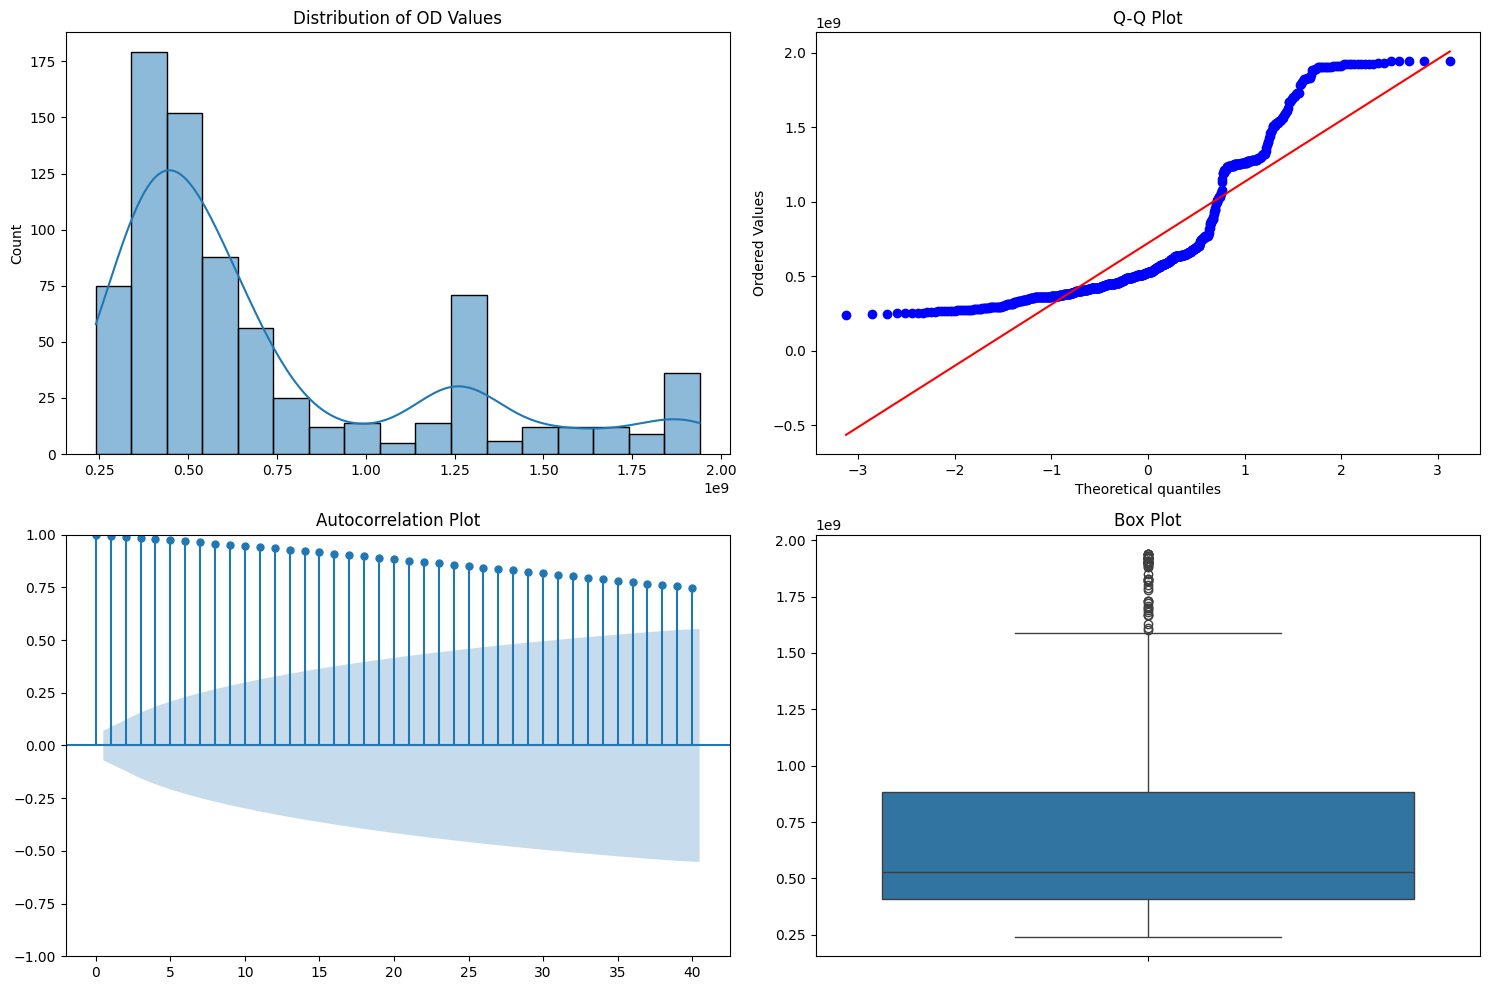


Basic Statistics:
Mean: 721964032.0000
Std: 457076448.0000
Min: 240000000.0000
Max: 1940000000.0000
Skewness: 1.3044
Kurtosis: 0.5516


In [5]:
# Statistical analysis of the data
data = OD.numpy()

# Create subplots for different visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with KDE
sns.histplot(data=data, kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of OD Values')

# Q-Q plot
stats.probplot(data, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot')

# Autocorrelation plot
sm.graphics.tsa.plot_acf(data, lags=40, ax=axes[1,0])
axes[1,0].set_title('Autocorrelation Plot')

# Box plot
sns.boxplot(data=data, ax=axes[1,1])
axes[1,1].set_title('Box Plot')
plt.tight_layout()
plt.show()

# Print basic statistics
print('\nBasic Statistics:')
print(f'Mean: {np.mean(data):.4f}')
print(f'Std: {np.std(data):.4f}')
print(f'Min: {np.min(data):.4f}')
print(f'Max: {np.max(data):.4f}')
print(f'Skewness: {stats.skew(data):.4f}')
print(f'Kurtosis: {stats.kurtosis(data):.4f}')

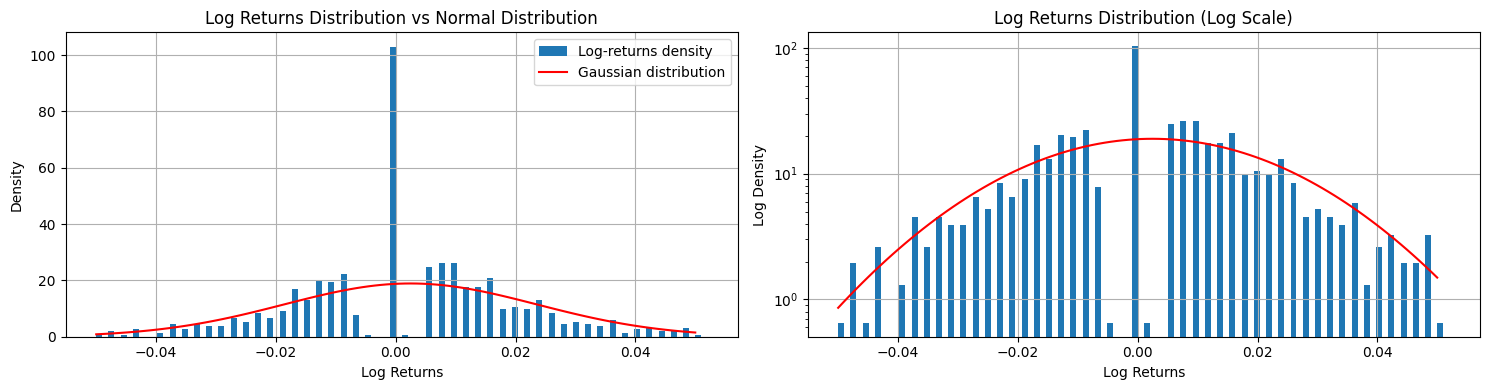


Log Returns Statistics:
Mean: 0.0025
Standard Deviation: 0.0211
Skewness: 0.0066
Kurtosis: 1.3363


In [6]:
# Analyze the distribution of log returns
# Convert PyTorch tensor to numpy array for plotting
OD_log_delta_np = OD_log_delta.numpy()

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# density of log-returns
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(OD_log_delta_np, bins=bin_edges, density=True, width=0.001, label='Log-returns density')
axes[0].grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(OD_log_delta_np)
sigma = np.std(OD_log_delta_np)

# Generate a set of points x
x = np.linspace(-0.05, 0.05, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes[0].plot(x, pdf, 'r', label='Gaussian distribution')
axes[0].legend()
axes[0].set_title('Log Returns Distribution vs Normal Distribution')
axes[0].set_xlabel('Log Returns')
axes[0].set_ylabel('Density')

# plot in logarithmic scale
axes[1].hist(OD_log_delta_np, bins=bin_edges, density=True, width=0.001, log=True)
axes[1].grid()
axes[1].set_title('Log Returns Distribution (Log Scale)')
axes[1].set_xlabel('Log Returns')
axes[1].set_ylabel('Log Density')

# plot the Gaussian PDF in logarithmic scale
axes[1].semilogy(x, pdf, 'r')
plt.tight_layout()
plt.show()

# Print some statistics about the log returns
print("\nLog Returns Statistics:")
print(f"Mean: {mu:.4f}")
print(f"Standard Deviation: {sigma:.4f}")
print(f"Skewness: {stats.skew(OD_log_delta_np):.4f}")
print(f"Kurtosis: {stats.kurtosis(OD_log_delta_np):.4f}")

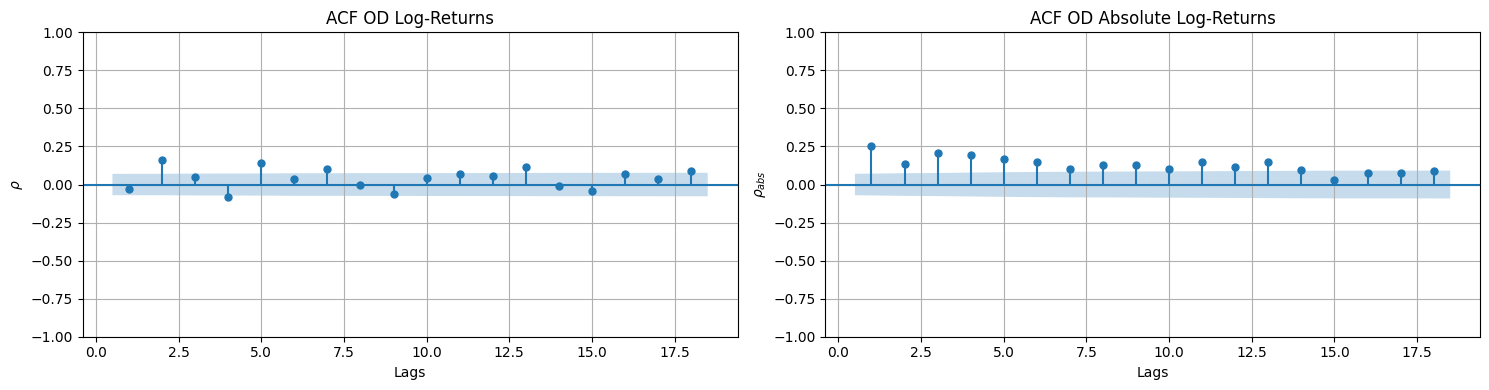


Autocorrelation Statistics:
First-order autocorrelation of log returns: -0.0300
First-order autocorrelation of absolute log returns: 0.2500


In [7]:
# Analyze autocorrelation in log returns
# Convert PyTorch tensor to numpy array for ACF plotting
OD_log_delta_np = OD_log_delta.numpy()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Plot ACF of log returns
tsaplots.plot_acf(OD_log_delta_np, lags=18, zero=False, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_title('ACF OD Log-Returns')
ax1.set_ylabel(r'$\rho$')
ax1.grid(True)

# Plot ACF of absolute log returns
tsaplots.plot_acf(np.abs(OD_log_delta_np), lags=18, zero=False, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_title('ACF OD Absolute Log-Returns')
ax2.set_ylabel(r'$\rho_{abs}$')
ax2.grid(True)
plt.tight_layout()
plt.show()

# Print some additional statistics about the autocorrelation
print("\nAutocorrelation Statistics:")

# Calculate first-order autocorrelation for both series
acf_log = sm.tsa.acf(OD_log_delta_np, nlags=1)[1]
acf_abs = sm.tsa.acf(np.abs(OD_log_delta_np), nlags=1)[1]
print(f"First-order autocorrelation of log returns: {acf_log:.4f}")
print(f"First-order autocorrelation of absolute log returns: {acf_abs:.4f}")

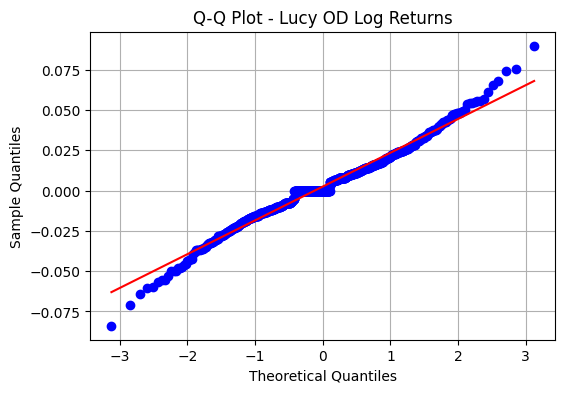

In [8]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(OD_log_delta, dist='norm', plot=plt)
plt.title('Q-Q Plot - Lucy OD Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

## Data Preprocessing Utilities

We'll define several utility functions for data preprocessing, including normalization, Lambert W transformation, and sliding window creation.


In [9]:
# Define utility functions for data preprocessing
def normalize(data):
    """Normalize the data to have zero mean and unit variance."""
    mu = torch.mean(data)
    sigma = torch.std(data)
    return (data - mu) / sigma  # Return only normalized data
def denormalize(norm_data, mu_original, std_original):
    """Denormalize the data back to original scale."""
    return norm_data * std_original + mu_original

In [10]:
# normalize the log-returns
norm_OD_log_delta = normalize(OD_log_delta)

# display the mean and standard deviation of the original log-returns
print(f'Original Lucy OD log-returns mean = {torch.mean(OD_log_delta)}, std = {torch.std(OD_log_delta)}')

# display the mean and standard deviation of the normalized log-returns
print(f'Normalized Lucy OD log-returns mean = {torch.mean(norm_OD_log_delta)}, std = {torch.std(norm_OD_log_delta)}')

Original Lucy OD log-returns mean = 0.002459787530824542, std = 0.02110857143998146
Normalized Lucy OD log-returns mean = 4.909520345819374e-09, std = 1.0


Original Data Min-Max
-0.08388137817382812 0.08982658386230469
Normalized Data Min-Max
-4.090336799621582 4.138925075531006


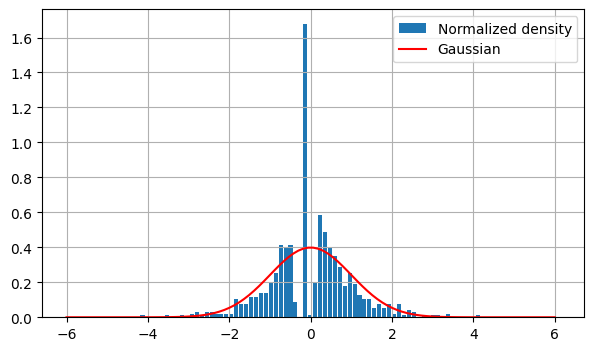

In [11]:
print('Original Data Min-Max')
print(torch.min(OD_log_delta).item(), torch.max(OD_log_delta).item())
print('Normalized Data Min-Max')
print(torch.min(norm_OD_log_delta).item(), torch.max(norm_OD_log_delta).item())
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of log-returns
bin_edges = np.linspace(-6, 6, num=100)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)

# Convert PyTorch tensor to numpy for matplotlib
axes.hist(norm_OD_log_delta.numpy(), bins=bin_edges, density=True, width=0.1, label='Normalized density')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = torch.mean(norm_OD_log_delta).item()  # Convert to Python scalar
sigma = torch.std(norm_OD_log_delta).item()  # Convert to Python scalar

# Generate a set of points x
x = np.linspace(-6, 6, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()
plt.show()

In [12]:
def inverse_lambert_w_transform(data, delta):
    """
    Apply inverse Lambert W transform to the input data using the specified delta value.
    Parameters:
    - data: Input data tensor
    - delta: Delta value for the transform (tail parameter)
    Returns:
    - Transformed data tensor
    """
    # Convert to float64 for precision
    data = data.double()
    
    sign = torch.sign(data)
    
    # Convert to numpy for lambertw, then back to tensor
    data_squared = data ** 2
    lambert_input = (delta * data_squared).cpu().numpy()
    lambert_result = lambertw(lambert_input).real
    
    # Convert back to tensor and apply transform
    lambert_tensor = torch.tensor(lambert_result, dtype=torch.float64, device=data.device)
    transformed_data = sign * torch.sqrt(lambert_tensor / delta)
    return transformed_data
def lambert_w_transform(transformed_data, delta, clip_low=-12.0, clip_high=11.0):
    """
    Transform the Gaussianized data back to its original state.
    Parameters:
    - transformed_data: Input data tensor which was transformed using inverse Lambert W
    - delta: Delta value for the transform (tail parameter)
    - clip_low: Lower clipping bound
    - clip_high: Upper clipping bound
    Returns:
    - Original Data tensor
    """
    # Convert to float64 for precision
    transformed_data = transformed_data.double()
    
    # Apply the reverse transform
    exp_term = torch.exp((delta / 2) * transformed_data ** 2)
    reversed_data = transformed_data * exp_term
    
    # Clip the values
    return torch.clamp(reversed_data, clip_low, clip_high)

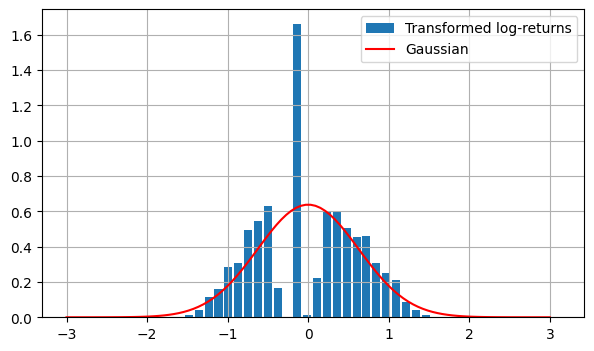

In [13]:
# apply inverse Lambert W transform to the normalized log-returns
delta = 1
transformed_norm_OD_log_delta = inverse_lambert_w_transform(norm_OD_log_delta, delta)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of normalized log-returns
bin_edges = np.linspace(-3, 3, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)

# Convert PyTorch tensor to numpy for matplotlib
axes.hist(transformed_norm_OD_log_delta.numpy(), bins=bin_edges, density=True, width=0.1, label='Transformed log-returns')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = torch.mean(transformed_norm_OD_log_delta).item()  # Convert to Python scalar
sigma = torch.std(transformed_norm_OD_log_delta).item()  # Convert to Python scalar

# Generate a set of points x
x = np.linspace(-3, 3, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the normalized log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()
plt.show()

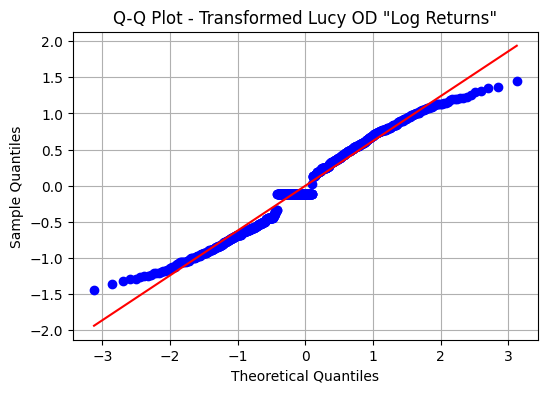

In [14]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(transformed_norm_OD_log_delta, dist='norm', plot=plt)
plt.title('Q-Q Plot - Transformed Lucy OD "Log Returns"')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [15]:
print('Transformed Data Min-Max')
print(torch.min(transformed_norm_OD_log_delta).item(), torch.max(transformed_norm_OD_log_delta).item())


Transformed Data Min-Max
-1.4433644659128437 1.4488887136715398


In [16]:
min_val = torch.min(transformed_norm_OD_log_delta)
max_val = torch.max(transformed_norm_OD_log_delta)
scaled_data = -1.0 + 2.0 * (transformed_norm_OD_log_delta - min_val) / (max_val - min_val)

print(f'Scaled Normalized Transformed log-returns mean = {torch.mean(scaled_data)}, std = {torch.std(scaled_data)}')
print('Scaled Normalized Transformed log-returns min-max: ', torch.min(scaled_data).item(), torch.max(scaled_data).item())


Scaled Normalized Transformed log-returns mean = -0.0016953676447610307, std = 0.4325888095928082
Scaled Normalized Transformed log-returns min-max:  -1.0 1.0


In [17]:
def rescale(scaled_data, original_data):
    """
    Scale back from [-1,1] to the previous range
    
    Parameters:
    - scaled_data: Data scaled to [-1, 1] range
    - original_data: Original data to get min/max values from
    
    Returns:
    - Rescaled data in original range
    """
    min_val = torch.min(original_data)
    max_val = torch.max(original_data)
    previous_data = 0.5 * (scaled_data + 1.0) * (max_val - min_val) + min_val
    
    return previous_data
def rolling_window(data, m, s):
    """
    Create rolling windows from data
    
    Parameters:
    - data: Input tensor
    - m: Window size
    - s: Step size (stride)
    
    Returns:
    - Tensor of rolling windows
    """
    # Calculate number of windows
    num_windows = (len(data) - m) // s + 1
    
    # Create indices for each window
    windows = []
    for i in range(0, len(data) - m + 1, s):
        windows.append(data[i:i+m])
    
    # Stack all windows into a tensor
    return torch.stack(windows)

In [18]:
# Enable best available device (CUDA > MPS > CPU)
device = torch.device(
            "cuda:0" if torch.cuda.is_available() 
            else "mps" if torch.backends.mps.is_available() 
            else "cpu"
        )
print(device)

mps


In [19]:
# Part 1 - __init__
class qGAN(nn.Module):
    def __init__(self, num_epochs, batch_size, window_length, n_critic, gp, num_layers, num_qubits):
        super().__init__()  # Modern Python 3+ syntax
        
        # classical hyperparameters
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.window_length = window_length
        self.n_critic = n_critic
        self.gp = gp
        
        # quantum hyperparameters
        self.num_layers = num_layers
        self.num_qubits = num_qubits 

        # Quantum device (for PennyLane)
        self.quantum_dev = qml.device("default.qubit", wires=self.num_qubits)
        
        # PyTorch device (for classical computation)
        self.torch_device = torch.device(
            "cuda:0" if torch.cuda.is_available() 
            else "mps" if torch.backends.mps.is_available() 
            else "cpu"
        )
        
        # quantum circuit settings
        self.qubits = list(range(num_qubits))  # PennyLane uses wire indices instead of GridQubit
        
        # create the set of Pauli strings to measure -> {X1, Z1, X2, Z2, etc}
        # X1 means we measure the first qubit only with X, Z1 the first qubit only with Z and so on...
        # Return measurements based on self.measurements (X and Z measurements)
        self.measurements = []
        for i in range(self.num_qubits):
            self.measurements.append(qml.expval(qml.PauliX(i)))  # X measurement
            self.measurements.append(qml.expval(qml.PauliZ(i)))  # Z measurement

        # number of parameters of the PQC and re-uploading layers
        self.num_params = self.count_params()

        # define the trainable parameters of the PQC main and re-uploading layers (trainable)
        self.params_pqc = torch.nn.Parameter(torch.randn(self.num_params, requires_grad=True))  # PyTorch parameters instead of sympy symbols

        # define the classical critic network (CNN)
        self.critic = self.define_critic_model(window_length)
        # define the quantum generator network (PQC)
        self.generator = self.define_generator_model()
        # Create QNode with proper PyTorch integration for gradient flow        
       
        # monitoring purposes
        # average critic and generator losses for each epoch
        self.critic_loss_avg = []
        self.generator_loss_avg = []

        # Earth's mover distance (EMD) for each epoch
        self.emd_avg = []

        # stylized facts RMSEs for each epoch
        self.acf_avg = []
        self.vol_avg = []
        self.lev_avg = []

# Part 2 - gen and critic models
    ####################################################################################
    #
    # count the parameters of the quantum circuit
    #
    ####################################################################################
    def count_params(self):
        # Per-qubit parameterization with RX, RY, RZ gates:
        # - For each layer: RX + RY + RZ (3 params) and a re-upload RX (1 param) => 4*layers
        # - Final layer: RX + RY + RZ => +3
        # Total per qubit = 4*layers + 3, multiplied by number of qubits
        return self.num_qubits * (4 * self.num_layers + 3)

    ####################################################################################
    #
    # the classical critic model as a convolutional network
    #
    ####################################################################################
    def define_critic_model(self, window_length):
        """Define the classical critic model"""
        model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=64, kernel_size=10, stride=1, padding=5),
        nn.LeakyReLU(negative_slope=0.1),
        
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=10, stride=1, padding=5),
        nn.LeakyReLU(negative_slope=0.1),
        
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=10, stride=1, padding=5),
        nn.LeakyReLU(negative_slope=0.1),
        
        # Add adaptive pooling to get fixed size
        nn.AdaptiveAvgPool1d(output_size=1),  # This gives 128 * 1 = 128 features ### verify if this needs to be here
        nn.Flatten(),
        
        nn.Linear(in_features=128, out_features=32),  # 128 -> 32
        nn.LeakyReLU(negative_slope=0.1),
        nn.Dropout(p=0.2),
        
        nn.Linear(in_features=32, out_features=1)
        )
    
        model = model.double()
        return model

    ####################################################################################
    #
    # the encoding layer: resolve the parameters by uniform noise values,
    # used to prepare the initial state for the generator circuit
    #
    ####################################################################################
    def encoding_layer(self, noise_params):
        """Helper function to apply encoding - used within qnode"""
        for i in range(self.num_qubits):
            qml.RX(phi=noise_params[i], wires=i)

    ####################################################################################
    #
    # the quantum generator as a PQC with All-to-all topology for the entangling layer
    #
    ####################################################################################
    def define_generator_circuit(self, noise_params, params_pqc):
        # Apply encoding layer
        self.encoding_layer(noise_params)
    
        # index for the parameter tensor of the PQC main and re-uploading layers
        idx = 0
    
        # Initial Hadamard gates
        for qubit in range(self.num_qubits):
            qml.Hadamard(wires=qubit)
    
        for layer in range(self.num_layers):
            ###############################################################
            #
            # single-qubit rotation layer
            #
            ###############################################################
            for qubit in range(self.num_qubits):
                qml.RX(phi=params_pqc[idx], wires=qubit)
                idx += 1
                qml.RY(phi=params_pqc[idx], wires=qubit)
                idx += 1
                qml.RZ(phi=params_pqc[idx], wires=qubit)
                idx += 1
            ###############################################################
            #
            # entangling layer (not parameterized)
            #
            ###############################################################
            for qubit1 in range(self.num_qubits):
                for qubit2 in range(qubit1+1, self.num_qubits):
                    qml.CNOT(wires=[qubit1, qubit2])
            ###############################################################
            #
            # re-uploading layer with Rx rotation
            #
            ###############################################################
            for qubit in range(self.num_qubits):
                qml.RX(phi=params_pqc[idx], wires=qubit)
                idx += 1
        #####################################################################
        #
        # single-qubit rotation layer as the last layer before measurement
        #
        #####################################################################
        for qubit in range(self.num_qubits):
            qml.RX(phi=params_pqc[idx], wires=qubit)
            idx += 1
            qml.RY(phi=params_pqc[idx], wires=qubit)
            idx += 1
            qml.RZ(phi=params_pqc[idx], wires=qubit)
            idx += 1
    
        measurements = []
        for i in range(self.num_qubits):
            measurements.append(qml.expval(qml.PauliX(i)))  # X measurement
            measurements.append(qml.expval(qml.PauliZ(i)))  # Z measurement
    
        return measurements

    ####################################################################################
    #
    # the quantum generator model
    #
    ####################################################################################
    def define_generator_model(self):
        
        # In PennyLane/PyTorch, we don't need explicit input definition like TensorFlow
        q_data_input = None  # Placeholder to match structure
    
        # define the pennylane quantum layer (trainable)
        generator = qml.QNode(self.define_generator_circuit, self.quantum_dev, interface='torch', diff_method='best')
    
        # generator output (will be computed when called)
        generator_output = generator
    
        # pytorch model equivalent
        model = generator
    
        return model

    #############################################################################
    #
    # compile model with given optimizers for critic and generator networks
    #
    #############################################################################
    def compile_QGAN(self, c_optimizer, g_optimizer):
        # PyTorch doesn't have a compile method like Keras
        # Just store the optimizers
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer

    def train_qgan(self, gan_data, original_data, preprocessed_data, num_elements):
        """
        Parameters:
        - gan_data is the preprocessed dataset with windows for qGAN training
        - original_data is the original S&P 500 log-returns for evaluation of RMSEs (monitoring purposes)
        - preprocessed_data is the preprocessed log-returns without the last normalization step and without windows
         (for reversing the process of generated samples using the mean and std and evaluating the RMSEs)
        """
        # Convert DataLoader to list for random sampling (PyTorch approach)
        gan_data_list = []

        for batch in gan_data:
            for sample in batch[0]:  # batch[0] contains the data
                gan_data_list.append(sample)
                
        # training loop
        for epoch in range(self.num_epochs):
            print(f'Processing epoch {epoch+1}/{self.num_epochs}')
            self._train_one_epoch(gan_data_list, original_data, preprocessed_data, epoch)

    def _train_one_epoch(self, gan_data_list, original_data, preprocessed_data, epoch: int):
        """Runs critic and generator steps and logs metrics for a single epoch."""
        ################################################################
        #
        # Train the critic for n_critic iterations
        # Process 'batch_size' samples in each iteration
        #
        ################################################################
        # critic loss for 'n_critic' iterations
        critic_t_sum = 0
        for t in range(self.n_critic):
            # zero gradients
            self.c_optimizer.zero_grad()

            # critic loss for 'batch_size' samples
            critic_sum = 0
            for i in range(self.batch_size):
                # Sample real data and a latent variable
                random_idx = torch.randint(0, len(gan_data_list), (1,))
                real_sample = gan_data_list[random_idx.item()]
                # reshape the real sample for compatibility with the first layer of the critic
                real_sample = torch.reshape(real_sample, (1, self.window_length))

                ##################################################
                #
                # Get the state prepared by the encoding circuit
                #
                ##################################################
                # generate noise parameters for the encoding layer
                noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)

                # convert to torch tensor for quantum circuit
                generator_input = torch.tensor(noise_values, dtype=torch.float32)

                # get the fake sample as the expectations of the quantum circuit
                generated_sample = self.generator(generator_input, self.params_pqc)

                # If QNode/module returns a list of tensors, stack to a single tensor
                if isinstance(generated_sample, list):
                    generated_sample = torch.stack(generated_sample)

                # Preserve autograd graph; just cast dtype
                generated_sample = generated_sample.to(torch.float64)

                # Reshape real sample and add channel dimension for Conv1D
                real_sample = torch.reshape(real_sample, (1, self.window_length))
                real_sample = real_sample.unsqueeze(1)  # [1, 1, window_length]
                real_sample = real_sample.double()

                # Reshape generated sample and add channel dimension
                generated_sample_input = generated_sample.unsqueeze(0).unsqueeze(1)  # [1, 1, window_length]

                # calculate the critic scores for real and fake samples
                real_score = self.critic(real_sample)
                fake_score = self.critic(generated_sample_input)

                # compute the gradient penalty
                gradient_penalty = self.compute_gradient_penalty(real_sample, generated_sample.unsqueeze(0))

                # calculate the Wasserstein distance loss with gradient penalty
                critic_loss = fake_score - real_score + self.gp * gradient_penalty

                # accumulate the critic loss for the sample
                critic_sum += critic_loss

            # compute the gradients of critic and apply them
            (critic_sum / self.batch_size).backward()
            self.c_optimizer.step()

            # accumulate the average critic loss for all samples in this 't' iteration
            critic_t_sum += critic_sum / self.batch_size

        # average critic loss for this epoch of WGAN training
        self.critic_loss_avg.append(critic_t_sum / self.n_critic)

        ################################################################
        #
        # Train generator for one iteration
        #
        ################################################################
        # sample a batch of input states using noise parameters (not encoding layer)
        input_circuits_batch = []

        for _ in range(self.batch_size):
            noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
            input_circuits_batch.append(noise_values)

        # convert to torch tensor batch
        generator_inputs = torch.stack([torch.tensor(noise, dtype=torch.float32) for noise in input_circuits_batch])

        # zero gradients
        self.g_optimizer.zero_grad()

        # generate fake samples using the generator
        generated_samples = []

        for generator_input in generator_inputs:
            gen_out = self.generator(generator_input, self.params_pqc)
            if isinstance(gen_out, list):
                gen_out = torch.stack(gen_out)
            generated_samples.append(gen_out.to(torch.float64))
        generated_samples = torch.stack(generated_samples)

        # Add channel dimension for Conv1D
        generated_samples_input = generated_samples.unsqueeze(1)  # [batch, 1, features]

        # calculate the critic scores for fake samples
        fake_scores = self.critic(generated_samples_input)

        # calculate the generator loss
        generator_loss = -torch.mean(fake_scores)

        # compute the gradients of generator and apply them
        generator_loss.backward()
        self.g_optimizer.step()

        # average generator loss for this epoch
        self.generator_loss_avg.append(generator_loss)

        ########################################################################################################
        #
        # Calculate the stylized facts RMSEs and the EMD for real and fake data
        #
        # Fake data has shape (num_samples x window_length), with num_samples = original_length / window_length
        # in order to get a time series close to the length of the original
        #
        ########################################################################################################
        # generate noise
        num_samples = len(original_data) // self.window_length
        input_circuits_batch = []

        for _ in range(num_samples):
            noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
            input_circuits_batch.append(noise_values)

        # convert to torch tensor batch
        generator_inputs = torch.stack([torch.tensor(noise, dtype=torch.float32) for noise in input_circuits_batch])

        # generate fake samples using the generator
        batch_generated = []

        for generator_input in generator_inputs:
            gen_out = self.generator(generator_input, self.params_pqc)
            if isinstance(gen_out, list):
                gen_out = torch.stack(gen_out)
            batch_generated.append(gen_out.to(torch.float64))
        batch_generated = torch.stack(batch_generated)

        # concatenate all time series data into one
        generated_data = torch.reshape(batch_generated, shape=(num_samples * self.window_length,))
        generated_data = generated_data.double()

        # rescale
        generated_data = rescale(generated_data, preprocessed_data)

        # reverse the preprocessing on generated sample
        original_norm = lambert_w_transform(generated_data, delta)
        fake_original = denormalize(original_norm, torch.mean(original_data), torch.std(original_data))

        # calculate the temporal metrics for monitoring the training process
        corr_rmse, volatility_rmse, lev_rmse, emd = self.stylized_facts(original_data, fake_original)

        # store the EMD and RMSEs of stylized facts
        self.acf_avg.append(corr_rmse)
        self.vol_avg.append(volatility_rmse)
        self.lev_avg.append(lev_rmse)
        self.emd_avg.append(emd)

        # print progress every 100 epochs
        if epoch % 100 == 0 or epoch + 1 == 3000:
            print(f'\nEpoch {epoch+1} completed')

        # Safe access to loss values with bounds checking
        if len(self.critic_loss_avg) > epoch:
            critic_loss_val = self.critic_loss_avg[epoch]
            if hasattr(critic_loss_val, 'item'):
                critic_loss_val = critic_loss_val.item()
            print(f'Critic loss (average): {critic_loss_val}')
        else:
            print(f'Critic loss (average): Not available (index {epoch}, list length {len(self.critic_loss_avg)})')

        if len(self.generator_loss_avg) > epoch:
            generator_loss_val = self.generator_loss_avg[epoch]
            if hasattr(generator_loss_val, 'item'):
                generator_loss_val = generator_loss_val.item()
            print(f'Generator loss (average): {generator_loss_val}')
        else:
            print(f'Generator loss (average): Not available (index {epoch}, list length {len(self.generator_loss_avg)})')

        # Safe access to other metrics
        if len(self.emd_avg) > epoch:
            print(f'\nEMD (average): {self.emd_avg[epoch]}')
            print(f'ACF RMSE (average): {self.acf_avg[epoch]}')
            print(f'VOLATILITY RMSE (average): {self.vol_avg[epoch]}')
            print(f'LEVERAGE RMSE (average): {self.lev_avg[epoch]}\n')
        else:
            print(f'\nMetrics not available for epoch {epoch}')

        # Only print min/max if variables exist
        try:
            print('Min-Max values of original log-returns: ', torch.min(original_data).item(), torch.max(original_data).item())
            print('Min-Max values of generated log-returns (for all batches): ', torch.min(fake_original).item(), torch.max(fake_original).item())
            print('Min-Max values after Lambert: ', torch.min(original_norm).item(), torch.max(original_norm).item())
        except NameError:
            print('Min-Max values not available (variables not defined)')
            print()

    ###########################################################
    #
    # Sample a random number epsilon ~ U[0,1]
    # Create a convex combination of real and generated sample
    # Compute the gradient penalty for the critic network
    #
    ###########################################################
    def compute_gradient_penalty(self, real_sample, generated_sample):
        epsilon = torch.rand(1, dtype=torch.float64)
        interpolated_sample = epsilon * real_sample + (1 - epsilon) * generated_sample
        interpolated_sample.requires_grad_(True)
        scores = self.critic(interpolated_sample)
        gradients = torch.autograd.grad(
            outputs=scores,
            inputs=interpolated_sample,
            grad_outputs=torch.ones_like(scores),
            create_graph=True,
            retain_graph=True
        )[0]
    
        gradients_norm = torch.norm(gradients)
        gradient_penalty = (gradients_norm - 1)**2
        return gradient_penalty

    def stylized_facts(self, original_data, fake_original):
        """
        - Calculate the RMSEs of the stylized facts between the original S&P 500 log-returns and
          generated time series
        - Evaluate the EMD between real and generated samples
        """
        # Ensure NumPy arrays for statsmodels and NumPy operations
        if isinstance(fake_original, torch.Tensor):
            fake_np = fake_original.detach().cpu().numpy()
        else:
            fake_np = np.asarray(fake_original)
        if isinstance(original_data, torch.Tensor):
            orig_np = original_data.detach().cpu().numpy()
        else:
            orig_np = np.asarray(original_data)

        ################################################
        #
        # stylized facts for fake samples
        #
        ################################################
        # compute acf for maximum lags = 18
        acf_values = sm.tsa.acf(fake_np, nlags=18)
        # exclude zero lag
        acf_values_generated = torch.tensor(acf_values[1:])
        # compute absolute acf (volatility clustering) for maximum lags = 18
        acf_abs_values = sm.tsa.acf(np.abs(fake_np), nlags=18)
        # exclude zero lag
        acf_abs_values_generated = torch.tensor(acf_abs_values[1:])
        # compute leverage effect for maximum lags = 18
        lev = []
        for lag in range(1, 19):
            # slice the tensors to get the appropriate lagged sequences
            r_t = fake_np[:-lag]
            squared_lag_r = np.square(np.abs(fake_np[lag:]))
            # calculate the leverage effect
            # calculate the correlation coefficient
            correlation_matrix = np.corrcoef(r_t, squared_lag_r)
            lev.append(correlation_matrix[0, 1])
        leverage_generated = torch.tensor(lev)

        ################################################
        #
        # stylized facts for real samples
        #
        ################################################
        # compute acf for maximum lags = 18
        acf_values = sm.tsa.acf(orig_np, nlags=18)

        # exclude zero lag
        acf_values_original = torch.tensor(acf_values[1:])

        # compute absolute acf (volatility clustering) for maximum lags = 18
        acf_abs_values = sm.tsa.acf(np.abs(orig_np), nlags=18)

        # exclude zero lag
        acf_abs_values_original = torch.tensor(acf_abs_values[1:])

        # compute leverage effect for maximum lags = 18
        lev = []

        for lag in range(1, 19):
            # slice the tensors to get the appropriate lagged sequences
            r_t = orig_np[:-lag]
            squared_lag_r = np.square(np.abs(orig_np[lag:]))
            # calculate the leverage effect
            correlation_matrix = np.corrcoef(r_t, squared_lag_r)
            lev.append(correlation_matrix[0, 1])
        leverage_original = torch.tensor(lev)

        # calculate average RMSEs of stylized facts
        # autocorrelations
        rmse_acf = torch.sqrt(torch.mean((acf_values_original-acf_values_generated)**2))

        # volatility clustering
        rmse_vol = torch.sqrt(torch.mean((acf_abs_values_original-acf_abs_values_generated)**2))

        # leverage effect
        rmse_lev = torch.sqrt(torch.mean((leverage_original-leverage_generated)**2))

        ####################################################################################
        #
        # compute the Earth's mover distance (EMD)
        #
        ####################################################################################
        bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
        bin_width = bin_edges[1] - bin_edges[0]
        bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)

        # compute the empirical distribution of original data
        empirical_real, _ = np.histogram(orig_np, bins=bin_edges, density=True)
        empirical_real /= np.sum(empirical_real)

        # compute the empirical distribution of generated data
        empirical_fake, _ = np.histogram(fake_np, bins=bin_edges, density=True)
        empirical_fake /= np.sum(empirical_fake)

        # evaluate the EMD using SciPy
        emd = wasserstein_distance(empirical_real, empirical_fake)
        return rmse_acf, rmse_vol, rmse_lev, emd

In [ ]:
##################################################################
#
# Hyperparameters
#
##################################################################
WINDOW_LENGTH = 10  # this must be equal to the number of Pauli strings to measure
NUM_QUBITS = 5  # number of qubits
NUM_LAYERS = 3 # number of layers for the PQC

# training hyperparameters
EPOCHS = 10 #200
BATCH_SIZE = 20
n_critic = 2 # number of iterations for the critic per epoch
LAMBDA = 10  # gradient penalty strength

# instantiate the QGAN model object
qgan = qGAN(EPOCHS, BATCH_SIZE, WINDOW_LENGTH, n_critic, LAMBDA, NUM_LAYERS, NUM_QUBITS)

# set the optimizers
c_optimizer = torch.optim.Adam(qgan.critic.parameters())
g_optimizer = torch.optim.Adam([qgan.params_pqc])  # Use the quantum parameters
qgan.compile_QGAN(c_optimizer, g_optimizer)

Circuit visualization:
0: ──RX(0.50)──H──RX(0.10)──RY(0.10)──RZ(0.10)─╭●─╭●─╭●─╭●──RX(0.10)──RX(0.10)──RY(0.10)──RZ(0.10)
1: ──RX(0.50)──H──RX(0.10)──RY(0.10)──RZ(0.10)─╰X─│──│──│──╭●────────╭●────────╭●─────────RX(0.10)
2: ──RX(0.50)──H──RX(0.10)──RY(0.10)──RZ(0.10)────╰X─│──│──╰X────────│─────────│─────────╭●───────
3: ──RX(0.50)──H──RX(0.10)──RY(0.10)──RZ(0.10)───────╰X─│────────────╰X────────│─────────╰X───────
4: ──RX(0.50)──H──RX(0.10)──RY(0.10)──RZ(0.10)──────────╰X─────────────────────╰X─────────────────

────────────────────────────────╭●──────────────────╭●────────╭●─╭●──RX(0.10)──RX(0.10)──RY(0.10)
───RX(0.10)──RY(0.10)──RZ(0.10)─╰X──────────────────│─────────│──│──╭●────────╭●────────╭●───────
──╭●─────────RX(0.10)──RX(0.10)──RY(0.10)──RZ(0.10)─╰X────────│──│──╰X────────│─────────│────────
──│─────────╭●─────────RX(0.10)──RX(0.10)──RY(0.10)──RZ(0.10)─╰X─│────────────╰X────────│────────
──╰X────────╰X─────────RX(0.10)──RX(0.10)──RY(0.10)──RZ(0.10)────╰X─────────────────────╰

/var/folders/x9/05_lgckd2f5fjpll2k2x6pkh0000gn/T/ipykernel_10247/402182754.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


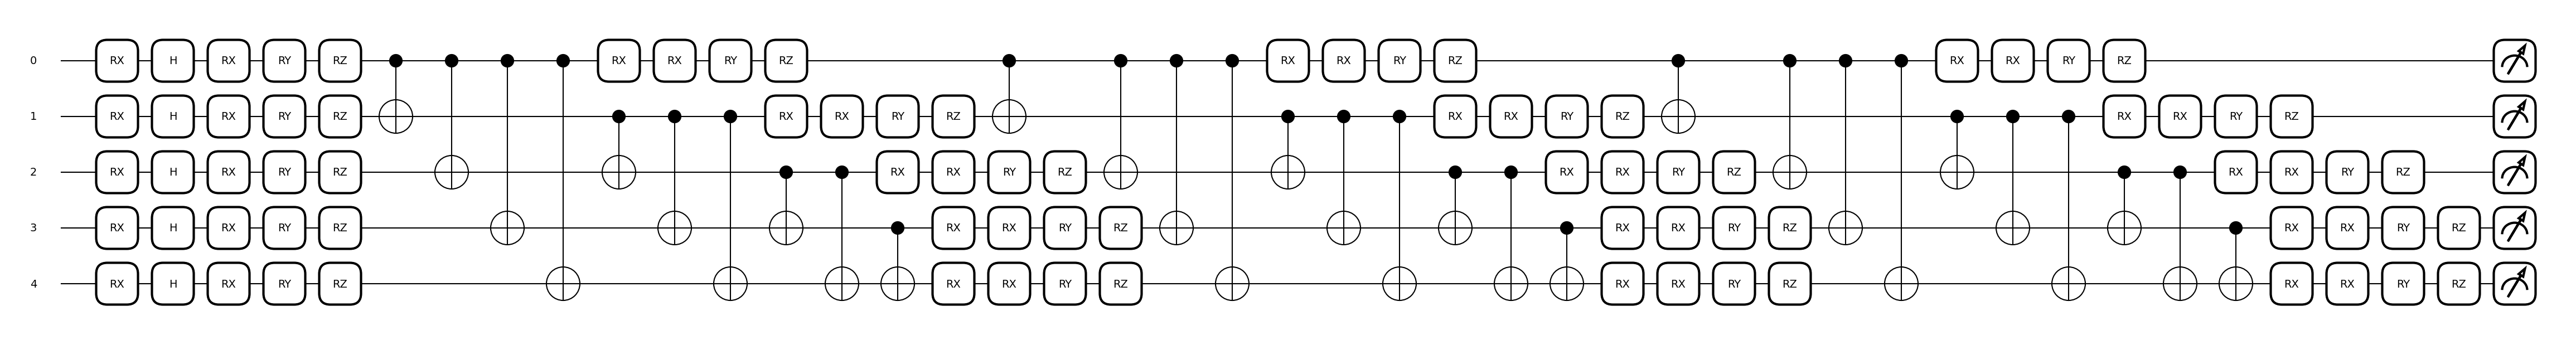

In [21]:
##################################################################################
#
# Data pre-processing
#
##################################################################################
# apply rolling window in transformed (scaled) log-returns with stride s=2
gan_data_tf = rolling_window(scaled_data, WINDOW_LENGTH, 2)

# create PyTorch datasets (handle both numpy array and tensor inputs)
if isinstance(gan_data_tf, np.ndarray):
    data_tensor = torch.from_numpy(gan_data_tf).float()
else:
    data_tensor = gan_data_tf.float()
gan_data = torch.utils.data.TensorDataset(data_tensor)
gan_data = torch.utils.data.DataLoader(gan_data, batch_size=1, shuffle=True)

# get the number of elements in the dataset
num_elements = len(gan_data_tf)

# Create dummy parameters for visualization
dummy_noise_params = torch.tensor([0.5] * NUM_QUBITS, dtype=torch.float32)
dummy_circuit_params = torch.tensor([0.1] * qgan.num_params, dtype=torch.float32)

# Use the correct attribute name 
print("Circuit visualization:")
print(qml.draw(qgan.generator)(dummy_noise_params, dummy_circuit_params))

# For matplotlib visualization:
fig, ax = qml.draw_mpl(qgan.generator)(dummy_noise_params, dummy_circuit_params)
fig.show()

In [22]:
# train the QGAN
print('Training started...')
print('Number of samples to process per epoch: ', num_elements)
print()
start_time_train = time.time()
model = qgan.train_qgan(gan_data, OD_log_delta, transformed_norm_OD_log_delta, num_elements)
exec_time_train = time.time() - start_time_train
print(f'\nQGAN training completed. Training time: --- {exec_time_train/3600:.02f} hours ---')

Training started...
Number of samples to process per epoch:  384

Processing epoch 1/200

Epoch 1 completed
Critic loss (average): 9.795254608234032
Generator loss (average): 0.025793329050200303

EMD (average): 0.011110665929814875
ACF RMSE (average): 0.10582776543504177
VOLATILITY RMSE (average): 0.14391510672359445
LEVERAGE RMSE (average): 0.05412676756220971

Min-Max values of original log-returns:  -0.08388137817382812 0.08982658386230469
Min-Max values of generated log-returns (for all batches):  -0.03347761904413556 0.029819940538342676
Min-Max values after Lambert:  -1.7025030176552614 1.2961631764286823
Processing epoch 2/200
Critic loss (average): 8.903294999524594
Generator loss (average): 0.03698160777831555

EMD (average): 0.010857142857142866
ACF RMSE (average): 0.0856778207677564
VOLATILITY RMSE (average): 0.12480986302867689
LEVERAGE RMSE (average): 0.04013775363450645

Min-Max values of original log-returns:  -0.08388137817382812 0.08982658386230469
Min-Max values of g

In [47]:
# Check training status - FIXED VERSION
print("QGAN Training Status:")
print(f"Epochs completed: {len(qgan.critic_loss_avg)}")
print(f"Generator parameters shape: {qgan.params_pqc.shape}")
print(f"Parameter range: [{qgan.params_pqc.min().item():.4f}, {qgan.params_pqc.max().item():.4f}]")

if len(qgan.critic_loss_avg) == 0:
    print("❌ MODEL NOT TRAINED - Run training cell first!")
else:
    print("✅ Model has been trained")
    # Convert tensors to scalars using .item() before formatting
    critic_loss = qgan.critic_loss_avg[-1]
    generator_loss = qgan.generator_loss_avg[-1]
    
    # Handle both tensor and scalar cases
    if hasattr(critic_loss, 'item'):
        critic_loss = critic_loss.item()
    if hasattr(generator_loss, 'item'):
        generator_loss = generator_loss.item()
    
    print(f"Final losses - Critic: {critic_loss:.4f}, Generator: {generator_loss:.4f}")

QGAN Training Status:
Epochs completed: 200
Generator parameters shape: torch.Size([75])
Parameter range: [-2.3072, 2.0841]
✅ Model has been trained
Final losses - Critic: -0.0500, Generator: 0.7860


Converted data shapes:
critic_loss: (200,), values: [ 9.79525461e+00  8.90329500e+00  6.79373258e+00  3.83479496e+00
  8.02046024e-01  1.82292678e+00  2.21231164e+00  7.26598459e-01
  8.41383895e-01  5.09452712e-01  8.65824289e-01  3.26032858e-01
  6.89488906e-01  3.26106153e-01  4.70152634e-01  5.07258266e-01
  3.42609669e-01  3.57894160e-01  4.01249714e-01  1.35601425e-01
  6.24746017e-01  3.63075025e-01  4.36153880e-02  2.12537752e-01
  1.77261677e-01  2.00830459e-01  2.40114871e-01  2.49555710e-01
  6.62584426e-02  2.20571335e-01  4.02815660e-01  1.54859505e-01
 -1.12856153e-01 -4.73206086e-02 -4.41385937e-02 -2.10515101e-01
 -1.78501778e-03 -1.16420895e-01 -1.14909051e-01  4.07813483e-03
 -6.33023717e-02 -1.89862291e-01 -1.86481090e-01 -3.23680263e-01
 -8.97902217e-02 -2.00639363e-01 -2.54884783e-01 -1.56229142e-01
 -3.96672256e-01 -2.51013760e-01 -1.92384708e-01 -4.07183017e-01
 -2.03184125e-01 -3.30236216e-01 -2.57181495e-01 -3.52883992e-01
 -1.50428674e-01 -4.05446493e-01 -2.48

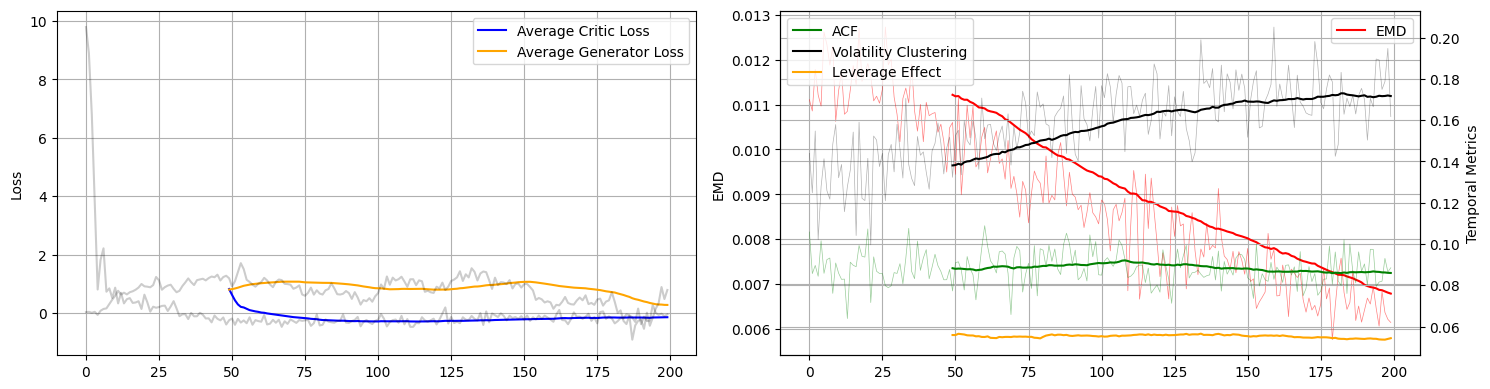

In [48]:
# Convert PyTorch data to match TensorFlow structure exactly
def convert_losses_pytorch_to_tf_format(critic_losses, generator_losses):
    """Convert PyTorch losses to match TensorFlow format"""
    
    # Handle critic losses - equivalent to tf.squeeze(qgan.critic_loss_avg, axis=(1,2)).numpy()
    if isinstance(critic_losses, list):
        critic_array = []
        for loss in critic_losses:
            if isinstance(loss, torch.Tensor):
                # Squeeze out extra dimensions and convert to scalar
                squeezed = loss.squeeze().detach().cpu().numpy()
                if squeezed.ndim == 0:  # scalar
                    critic_array.append(squeezed.item())
                else:
                    critic_array.append(squeezed)
            else:
                critic_array.append(loss)
        critic_loss = np.array(critic_array)
    else:
        critic_loss = np.array(critic_losses).squeeze()
    
    # Handle generator losses - equivalent to np.array(qgan.generator_loss_avg)
    if isinstance(generator_losses, list):
        gen_array = []
        for loss in generator_losses:
            if isinstance(loss, torch.Tensor):
                gen_array.append(loss.detach().cpu().numpy().item())
            else:
                gen_array.append(loss)
        generator_loss = np.array(gen_array)
    else:
        generator_loss = np.array(generator_losses)
    
    return critic_loss, generator_loss

# Convert the data
critic_loss, generator_loss = convert_losses_pytorch_to_tf_format(
    qgan.critic_loss_avg, qgan.generator_loss_avg
)
print(f"Converted data shapes:")
print(f"critic_loss: {critic_loss.shape}, values: {critic_loss}")
print(f"generator_loss: {generator_loss.shape}, values: {generator_loss}")

# Check if we have enough data for the original plotting logic
if len(critic_loss) < 50:
    print(f"WARNING: Only {len(critic_loss)} epochs of data. Original code expects more for moving average.")
    print("This suggests training stopped early or only ran for a few epochs.")
    
    # For small datasets, use a smaller window or no moving average
    if len(critic_loss) > 1:
        window = min(5, len(critic_loss))  # Use smaller window
        print(f"Using reduced window size: {window}")
    else:
        print("Cannot create moving average with only 1 data point.")
        # Show the single value
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(['Critic Loss', 'Generator Loss'], [critic_loss[0], generator_loss[0]])
        ax.set_title('Single Epoch Results')
        plt.show()
        exit()
else:
    window = 50

# plot the moving average
generator_ma = np.convolve(generator_loss, np.ones(window)/window, mode='valid')
critic_ma = np.convolve(critic_loss, np.ones(window)/window, mode='valid')

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# plot the critic loss moving average as a line
axes[0].plot(range(window-1, len(critic_loss)), critic_ma, label='Average Critic Loss', color='blue')

# plot the critic loss
axes[0].plot(critic_loss, color='black', alpha=0.2)

# plot the generator loss moving average as a line
axes[0].plot(range(window-1, len(generator_loss)), generator_ma, label='Average Generator Loss', color='orange')

# plot the generator loss
axes[0].plot(generator_loss, color='black', alpha=0.2)
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# Convert other metrics
emd_avg = np.array([x.item() if isinstance(x, torch.Tensor) else x for x in qgan.emd_avg])
emd_ma = np.convolve(emd_avg, np.ones(window)/window, mode='valid')

axes[1].plot(range(window-1, len(emd_avg)), emd_ma, label='EMD', color='red')
axes[1].plot(emd_avg, color='red', linewidth=0.5, alpha=0.5)
axes[1].set_ylabel('EMD')
axes[1].legend()
axes[1].grid()

acf_avg = np.array([x.item() if isinstance(x, torch.Tensor) else x for x in qgan.acf_avg])
vol_avg = np.array([x.item() if isinstance(x, torch.Tensor) else x for x in qgan.vol_avg])
lev_avg = np.array([x.item() if isinstance(x, torch.Tensor) else x for x in qgan.lev_avg])

acf_ma = np.convolve(acf_avg, np.ones(window)/window, mode='valid')
vol_ma = np.convolve(vol_avg, np.ones(window)/window, mode='valid')
lev_ma = np.convolve(lev_avg, np.ones(window)/window, mode='valid')

# Creating a twin axes for the second graph
axes2 = axes[1].twinx()
axes2.plot(range(window-1, len(acf_avg)), acf_ma, label='ACF', color='green')
axes2.plot(acf_avg, color='green', linewidth=0.5, alpha=0.4)
axes2.plot(range(window-1, len(vol_avg)), vol_ma, label='Volatility Clustering', color='black')
axes2.plot(vol_avg, color='black', linewidth=0.5, alpha=0.3)
axes2.plot(range(window-1, len(lev_avg)), lev_ma, label='Leverage Effect', color='orange')
axes2.set_ylabel('Temporal Metrics')
axes2.legend()
axes2.grid()

# Adjusting the spacing between subplots
plt.tight_layout()
plt.show()

In [25]:
print(f"window: {window}, len(critic_loss): {len(critic_loss)}")

window: 50, len(critic_loss): 200


🚀 Starting QGAN Generation Pipeline Debug and Fix...
🔍 QGAN GENERATION PIPELINE DEBUGGER

1️⃣ VARIABLE EXISTENCE CHECK
------------------------------
✅ qgan: Found
✅ OD_log_delta: Found
✅ transformed_norm_OD_log_delta: Found
✅ WINDOW_LENGTH: Found
✅ NUM_QUBITS: Found

2️⃣ TRAINING STATUS
------------------------------
✅ Training epochs: 200
✅ Parameter range: [-2.3072, 2.0841]

3️⃣ QUANTUM GENERATOR TEST
------------------------------
✅ Generator output shape: torch.Size([10])
✅ Generator output range: [-0.477931, 0.616738]

4️⃣ FULL GENERATION PIPELINE
------------------------------
Generating 20 samples...
✅ Generated batch shape: torch.Size([20, 10])
✅ Reshaped data: torch.Size([200]), range [-0.842503, 0.888305]
✅ After rescale: range [-1.215603, 1.287364]
✅ After Lambert W: range [-2.544886, 2.948361]
✅ Final data: range [-0.051259, 0.064695]
✅ Generation pipeline completed successfully!

5️⃣ CREATING PLOTS
------------------------------
✅ Real data: 777 points, range [-0.083881, 

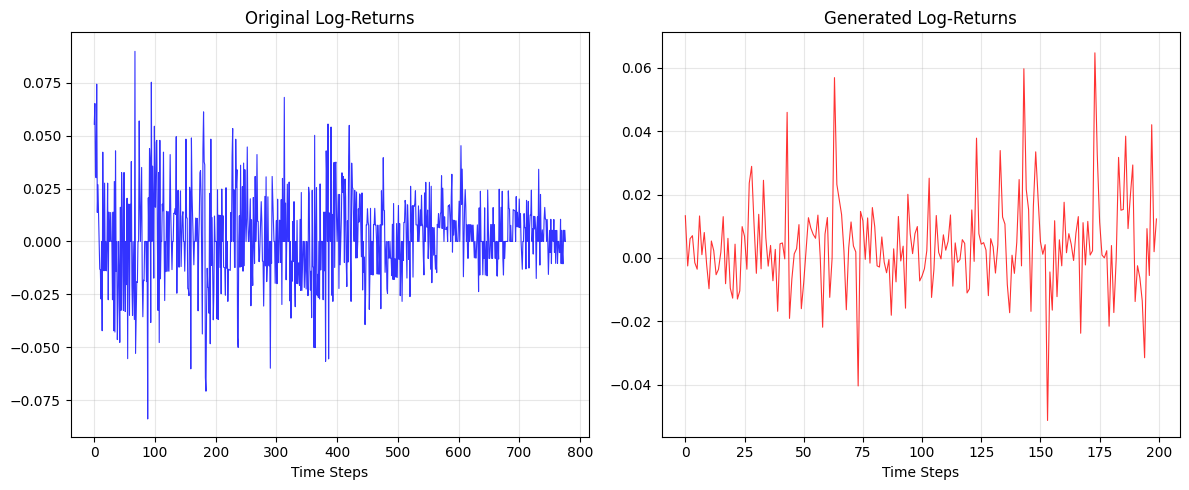

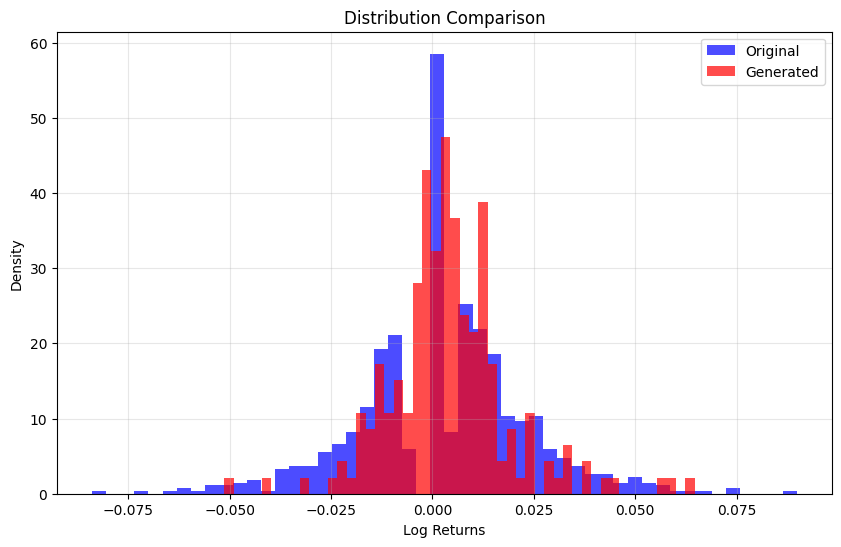

✅ Plots created successfully!

Statistics Comparison:
Original  - Mean: 0.002460, Std: 0.021095
Generated - Mean: 0.004120, Std: 0.015043

🎉 SUCCESS! Generation pipeline is now working!
Your QGAN is successfully generating synthetic time series data.

🔍 DEBUGGING COMPLETE


In [56]:
# ============================================================================
# QGAN GENERATION PIPELINE DEBUGGER - NOTEBOOK VERSION
# Copy and paste this entire cell into your Jupyter notebook
# ============================================================================

def debug_and_fix_generation():
    """
    Complete debugging and fixing of QGAN generation pipeline
    Run this cell to diagnose and fix generation issues
    """
    print("🔍 QGAN GENERATION PIPELINE DEBUGGER")
    print("=" * 60)
    
    # Step 1: Check if all required variables exist
    print("\n1️⃣ VARIABLE EXISTENCE CHECK")
    print("-" * 30)
    
    required_vars = ['qgan', 'OD_log_delta', 'transformed_norm_OD_log_delta', 'WINDOW_LENGTH', 'NUM_QUBITS']
    missing_vars = []
    
    for var_name in required_vars:
        try:
            var_value = eval(var_name)
            print(f"✅ {var_name}: Found")
        except NameError:
            print(f"❌ {var_name}: MISSING!")
            missing_vars.append(var_name)
    
    if missing_vars:
        print(f"\n❌ Missing variables: {missing_vars}")
        print("Please ensure all required variables are defined before running generation code.")
        return None
    
    # Step 2: Check training status
    print("\n2️⃣ TRAINING STATUS")
    print("-" * 30)
    
    epochs = len(qgan.critic_loss_avg)
    if epochs == 0:
        print("❌ MODEL NOT TRAINED! Run training cell first.")
        return None
    
    param_min = qgan.params_pqc.min().item()
    param_max = qgan.params_pqc.max().item()
    print(f"✅ Training epochs: {epochs}")
    print(f"✅ Parameter range: [{param_min:.4f}, {param_max:.4f}]")
    
    # Step 3: Test quantum generator
    print("\n3️⃣ QUANTUM GENERATOR TEST")
    print("-" * 30)
    
    try:
        # Test single generation
        test_noise = np.random.uniform(0, 2 * np.pi, size=NUM_QUBITS)
        test_input = torch.tensor(test_noise, dtype=torch.float32)
        
        with torch.no_grad():
            test_output = qgan.generator(test_input, qgan.params_pqc)
        
        if isinstance(test_output, list):
            test_output = torch.stack(test_output)
        
        out_min, out_max = test_output.min().item(), test_output.max().item()
        print(f"✅ Generator output shape: {test_output.shape}")
        print(f"✅ Generator output range: [{out_min:.6f}, {out_max:.6f}]")
        
        if torch.isnan(test_output).any():
            print("❌ Generator produces NaN values!")
            return None
        
        if out_min == out_max:
            print("❌ Generator produces constant values!")
            return None
            
    except Exception as e:
        print(f"❌ Generator test failed: {e}")
        return None
    
    # Step 4: Full generation with debugging
    print("\n4️⃣ FULL GENERATION PIPELINE")
    print("-" * 30)
    
    try:
        # Generate samples with debugging
        num_samples = min(len(OD_log_delta) // WINDOW_LENGTH, 20)  # Limit for debugging
        print(f"Generating {num_samples} samples...")
        
        # Generate noise batch
        input_circuits_batch = []
        for _ in range(num_samples):
            noise_values = np.random.uniform(0, 2 * np.pi, size=NUM_QUBITS)
            input_circuits_batch.append(noise_values)
        
        generator_inputs = torch.stack([torch.tensor(noise, dtype=torch.float32) for noise in input_circuits_batch])
        
        # Generate samples
        batch_generated = []
        for generator_input in generator_inputs:
            with torch.no_grad():  # Important: disable gradients for generation
                generated_sample = qgan.generator(generator_input, qgan.params_pqc)
                if isinstance(generated_sample, list):
                    generated_sample = torch.stack(generated_sample)
                batch_generated.append(generated_sample.to(torch.float64))
        
        batch_generated = torch.stack(batch_generated)
        print(f"✅ Generated batch shape: {batch_generated.shape}")
        
        # Reshape
        generated_data = torch.reshape(batch_generated, shape=(num_samples * WINDOW_LENGTH,))
        gen_min, gen_max = generated_data.min().item(), generated_data.max().item()
        print(f"✅ Reshaped data: {generated_data.shape}, range [{gen_min:.6f}, {gen_max:.6f}]")
        
        # Rescale step
        generated_data_rescaled = rescale(generated_data, transformed_norm_OD_log_delta)
        resc_min, resc_max = generated_data_rescaled.min().item(), generated_data_rescaled.max().item()
        print(f"✅ After rescale: range [{resc_min:.6f}, {resc_max:.6f}]")
        
        # Lambert W transform
        original_norm = lambert_w_transform(generated_data_rescaled, 1)
        lamb_min, lamb_max = original_norm.min().item(), original_norm.max().item()
        print(f"✅ After Lambert W: range [{lamb_min:.6f}, {lamb_max:.6f}]")
        
        # Denormalize
        fake_original = denormalize(original_norm, torch.mean(OD_log_delta), torch.std(OD_log_delta))
        final_min, final_max = fake_original.min().item(), fake_original.max().item()
        print(f"✅ Final data: range [{final_min:.6f}, {final_max:.6f}]")
        
        # Check for issues
        if torch.isnan(fake_original).any():
            print("❌ Final data contains NaN values!")
            return None
        
        if final_min == final_max:
            print("❌ Final data is constant!")
            return None
        
        print("✅ Generation pipeline completed successfully!")
        
        return fake_original
        
    except Exception as e:
        print(f"❌ Generation pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None

def create_fixed_plots(fake_original):
    """
    Create plots with proper error handling and debugging
    """
    if fake_original is None:
        print("❌ No data to plot!")
        return
    
    print("\n5️⃣ CREATING PLOTS")
    print("-" * 30)
    
    try:
        # Convert to numpy
        OD_log_delta_np = OD_log_delta.detach().cpu().numpy()
        fake_OD_log_delta_np = fake_original.detach().cpu().numpy()
        
        print(f"✅ Real data: {len(OD_log_delta_np)} points, range [{OD_log_delta_np.min():.6f}, {OD_log_delta_np.max():.6f}]")
        print(f"✅ Fake data: {len(fake_OD_log_delta_np)} points, range [{fake_OD_log_delta_np.min():.6f}, {fake_OD_log_delta_np.max():.6f}]")
        
        # Create figure
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        # Plot original data
        axes[0].plot(OD_log_delta_np, 'b-', linewidth=0.8, alpha=0.8)
        axes[0].set_xlabel('Time Steps')
        axes[0].set_title('Original Log-Returns')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_ylim([OD_log_delta_np.min() * 1.1, OD_log_delta_np.max() * 1.1])
        
        # Plot generated data
        axes[1].plot(fake_OD_log_delta_np, 'r-', linewidth=0.8, alpha=0.8)
        axes[1].set_xlabel('Time Steps')
        axes[1].set_title('Generated Log-Returns')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([fake_OD_log_delta_np.min() * 1.1, fake_OD_log_delta_np.max() * 1.1])
        
        plt.tight_layout()
        plt.show()
        
        # Create comparison histogram
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(OD_log_delta_np, bins=50, alpha=0.7, label='Original', density=True, color='blue')
        ax.hist(fake_OD_log_delta_np, bins=50, alpha=0.7, label='Generated', density=True, color='red')
        ax.set_xlabel('Log Returns')
        ax.set_ylabel('Density')
        ax.set_title('Distribution Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.show()
        
        print("✅ Plots created successfully!")
        
        # Print statistics
        print(f"\nStatistics Comparison:")
        print(f"Original  - Mean: {np.mean(OD_log_delta_np):.6f}, Std: {np.std(OD_log_delta_np):.6f}")
        print(f"Generated - Mean: {np.mean(fake_OD_log_delta_np):.6f}, Std: {np.std(fake_OD_log_delta_np):.6f}")
        
        return True
        
    except Exception as e:
        print(f"❌ Plotting failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("🚀 Starting QGAN Generation Pipeline Debug and Fix...")

# Run the debugging
fake_original = debug_and_fix_generation()

# Create plots if generation succeeded
if fake_original is not None:
    success = create_fixed_plots(fake_original)
    
    if success:
        print("\n🎉 SUCCESS! Generation pipeline is now working!")
        print("Your QGAN is successfully generating synthetic time series data.")
    else:
        print("\n⚠️ Generation worked but plotting failed. Check plot code.")
else:
    print("\n❌ Generation pipeline has issues. Check the debug output above.")
    print("\nCommon fixes:")
    print("1. Ensure model is trained (run training cell)")
    print("2. Check that all variables are defined")
    print("3. Verify preprocessing functions are available")
    print("4. Check for NaN/Inf values in data")

print("\n" + "=" * 60)
print("🔍 DEBUGGING COMPLETE")
print("=" * 60)


num_samples: 77
WINDOW_LENGTH: 10
generator_inputs shape: torch.Size([77, 5])
batch_generated shape: torch.Size([77, 10])
generated_data shape: torch.Size([770])
generated_data range: [-0.925816, 0.910030]
After rescale: [-1.336085, 1.318781]
After Lambert W: [-3.261884, 3.146527]
Final fake_original: [-0.066394, 0.068878]
=== DEBUGGING GENERATION ISSUE ===
OD_log_delta shape: torch.Size([777])
OD_log_delta range: [-0.083881, 0.089827]
OD_log_delta first 5 values: [0.05537796 0.06516838 0.03105927 0.03012276 0.07431984]
fake_original shape: torch.Size([770])
fake_original range: [-0.066394, 0.068878]
fake_original first 5 values: [ 0.00229041  0.02171791 -0.0119317   0.05097873 -0.01962617]

=== GENERATION PIPELINE DEBUG ===
✅ num_samples: 77
✅ generated_data: shape torch.Size([770]), range [-1.336085, 1.318781]
✅ original_norm: shape torch.Size([770]), range [-3.261884, 3.146527]
✅ fake_original: shape torch.Size([770]), range [-0.066394, 0.068878]
Plotting data - Real: 777 points, Fa

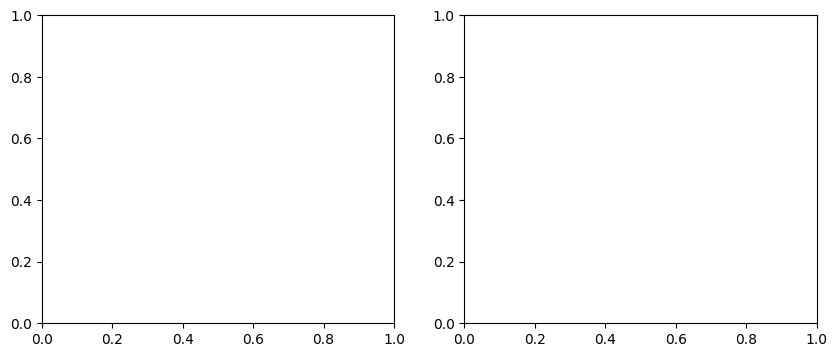

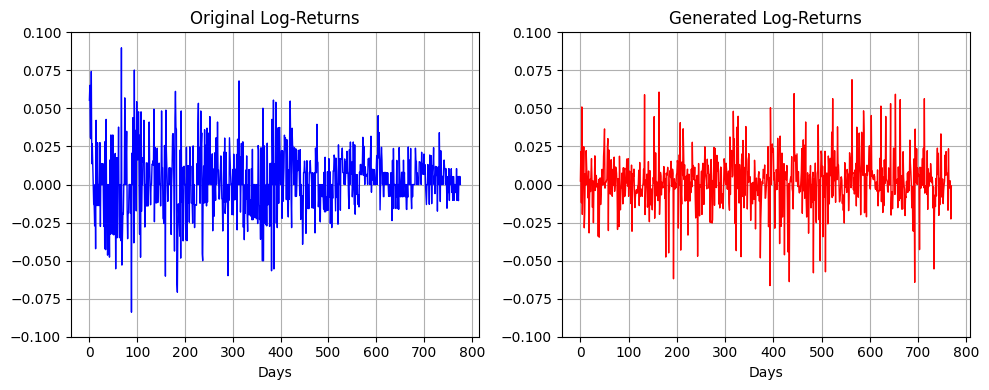

Real data stats: mean=0.002460, std=0.021095
Fake data stats: mean=0.002230, std=0.017273


In [53]:
# generate noise
num_samples = len(OD_log_delta) // WINDOW_LENGTH
print(f"num_samples: {num_samples}")
print(f"WINDOW_LENGTH: {WINDOW_LENGTH}")

input_circuits_batch = []

for _ in range(num_samples):
    noise_values = np.random.uniform(0, 2 * np.pi, size=NUM_QUBITS)
    input_circuits_batch.append(noise_values)  # Store noise values, not encoding layer result ### -check this shit out? we need encoding layer

# convert to torch tensor batch
generator_inputs = torch.stack([torch.tensor(noise, dtype=torch.float32) for noise in input_circuits_batch])
print(f"generator_inputs shape: {generator_inputs.shape}")
# generate fake samples using the generator
batch_generated = []

for generator_input in generator_inputs:
    generated_sample = qgan.generator(generator_input, qgan.params_pqc)
    if isinstance(generated_sample, list):
        generated_sample = torch.stack(generated_sample)
    batch_generated.append(generated_sample.to(torch.float64))
    # Debug first few samples
    if i < 3:
        print(f"Sample {i} generated: {generated_sample[:5].detach().cpu().numpy()}")

batch_generated = torch.stack(batch_generated)
print(f"batch_generated shape: {batch_generated.shape}")
# concatenate all time series data into one
generated_data = torch.reshape(batch_generated, shape=(num_samples * WINDOW_LENGTH,))
generated_data = generated_data.double()
print(f"generated_data shape: {generated_data.shape}")
print(f"generated_data range: [{generated_data.min().item():.6f}, {generated_data.max().item():.6f}]")

# rescale
generated_data = rescale(generated_data, transformed_norm_OD_log_delta)
print(f"After rescale: [{generated_data.min().item():.6f}, {generated_data.max().item():.6f}]")

# reverse the preprocessing on generated sample
original_norm = lambert_w_transform(generated_data, 1)
print(f"After Lambert W: [{original_norm.min().item():.6f}, {original_norm.max().item():.6f}]")

fake_original = denormalize(original_norm, torch.mean(OD_log_delta), torch.std(OD_log_delta))
print(f"Final fake_original: [{fake_original.min().item():.6f}, {fake_original.max().item():.6f}]")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))


# Debug: Check variable existence and content
print("=== DEBUGGING GENERATION ISSUE ===")

# Check if variables exist
try:
    print(f"OD_log_delta shape: {OD_log_delta.shape}")
    print(f"OD_log_delta range: [{OD_log_delta.min().item():.6f}, {OD_log_delta.max().item():.6f}]")
    print(f"OD_log_delta first 5 values: {OD_log_delta[:5].detach().cpu().numpy()}")
except NameError:
    print("❌ OD_log_delta not defined!")

try:
    print(f"fake_original shape: {fake_original.shape}")
    print(f"fake_original range: [{fake_original.min().item():.6f}, {fake_original.max().item():.6f}]")
    print(f"fake_original first 5 values: {fake_original[:5].detach().cpu().numpy()}")
except NameError:
    print("❌ fake_original not defined! Need to run generation code first.")


# Debug: Check generation pipeline step by step
print("\n=== GENERATION PIPELINE DEBUG ===")

# Check if generation variables exist
variables_to_check = ['num_samples', 'generated_data', 'original_norm', 'fake_original']
for var_name in variables_to_check:
    try:
        var_value = locals()[var_name]
        if hasattr(var_value, 'shape'):
            print(f"✅ {var_name}: shape {var_value.shape}, range [{var_value.min():.6f}, {var_value.max():.6f}]")
        else:
            print(f"✅ {var_name}: {var_value}")
    except KeyError:
        print(f"❌ {var_name}: NOT DEFINED")

# Create plot with explicit debugging
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# Convert to numpy explicitly
OD_log_delta_np = OD_log_delta.detach().cpu().numpy()
fake_OD_log_delta_np = fake_original.detach().cpu().numpy()

print(f"Plotting data - Real: {len(OD_log_delta_np)} points, Fake: {len(fake_OD_log_delta_np)} points")

# Plot original
axes[0].plot(OD_log_delta_np, 'b-', linewidth=1)
axes[0].set_xlabel('Days')
axes[0].set_title('Original Log-Returns')
axes[0].grid(True)
axes[0].set_ylim([-0.1, 0.1])

# Plot generated
axes[1].plot(fake_OD_log_delta_np, 'r-', linewidth=1)
axes[1].set_xlabel('Days')
axes[1].set_title('Generated Log-Returns') 
axes[1].grid(True)
axes[1].set_ylim([-0.1, 0.1])

plt.tight_layout()
plt.show()

# Additional check
print(f"Real data stats: mean={np.mean(OD_log_delta_np):.6f}, std={np.std(OD_log_delta_np):.6f}")
print(f"Fake data stats: mean={np.mean(fake_OD_log_delta_np):.6f}, std={np.std(fake_OD_log_delta_np):.6f}")

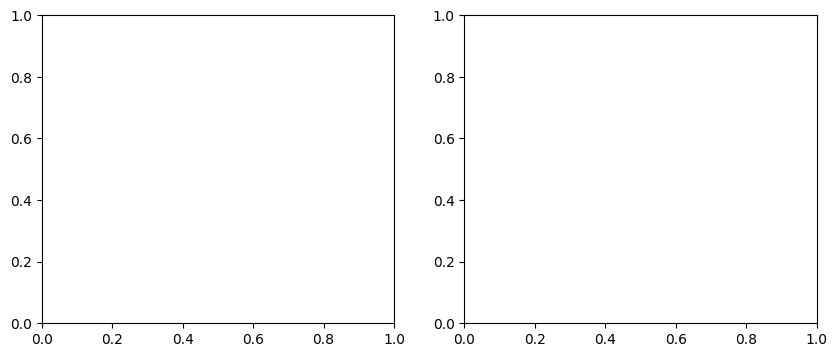

In [57]:
###################################################################################################################
#
# plot original log-returns on the left and the generated on the right
#
###################################################################################################################
# Convert PyTorch tensors to numpy for plotting
OD_log_delta_np = OD_log_delta.detach().cpu().numpy() if isinstance(OD_log_delta, torch.Tensor) else np.asarray(OD_log_delta)
fake_OD_log_delta_np = fake_original.detach().cpu().numpy() if isinstance(fake_original, torch.Tensor) else np.asarray(fake_original)

# Create DataFrames for later visualization code
# Generate date range for the data (assuming daily data)
import pandas as pd
from datetime import datetime, timedelta

start_date = datetime(2020, 1, 1)
real_dates = [start_date + timedelta(days=i) for i in range(len(OD_log_delta_np))]
fake_dates = [start_date + timedelta(days=i) for i in range(len(fake_OD_log_delta_np))]

real_data = pd.DataFrame({
    'DATE': real_dates,
    'Log_Return': OD_log_delta_np.flatten()
})

fake_data = pd.DataFrame({
    'DATE': fake_dates,
    'Log_Return': fake_OD_log_delta_np.flatten()
})

# Plot using index on x-axis (no 'date' available) 
axes[0].plot(OD_log_delta_np)
axes[0].set_xlabel('Days')
axes[0].set_title('Original Log-Returns')
axes[0].grid()
axes[0].set_ylim([-0.1, 0.1])
axes[1].plot(fake_OD_log_delta_np)
axes[1].set_xlabel('Days')
axes[1].set_title('Generated Log-Returns') 
axes[1].grid()
axes[1].set_ylim([-0.1, 0.1])
plt.show()


# Save generated series to CSV
df = pd.DataFrame(fake_OD_log_delta_np, columns=['generated_log_return'])
csv_filename = 'fake_original_OD_log_delta.csv'
df.to_csv(csv_filename, index=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

<Figure size 640x480 with 0 Axes>

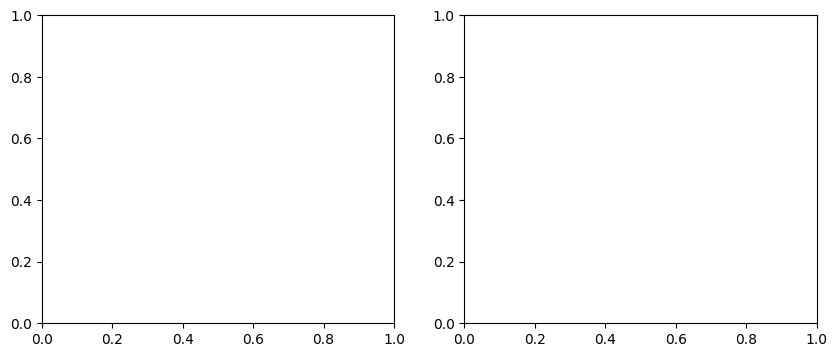

In [28]:
###################################################################################################################
#
# plot histogram of generated along with original log-returns on the left and the Q-Q plot on the right
#
###################################################################################################################
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)

orig_hist_np = OD_log_delta.detach().cpu().numpy() if isinstance(OD_log_delta, torch.Tensor) else np.asarray(OD_log_delta)

axes[0].hist(fake_OD_log_delta_np, bins=bin_edges, density=True, width=0.001, label='Generated', alpha=0.9)
axes[0].hist(orig_hist_np, bins=bin_edges, density=True, width=0.001, label='Original', alpha=0.8)
axes[0].set_title('Original vs Generated Density')
axes[0].grid()
axes[0].legend()

probplot(fake_OD_log_delta_np, dist='norm', plot=axes[1])
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].grid()
plt.subplots_adjust(wspace=0.3)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

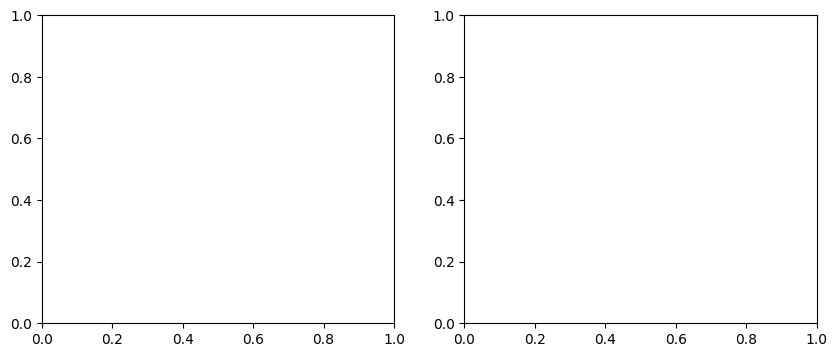

In [29]:
###################################################################################################################
#
# plot autocorrelations of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(OD_log_delta, ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Log-Returns')
axes[0].grid()

tsaplots.plot_acf(fake_OD_log_delta_np, ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Log-Returns (Generated)')
axes[1].grid()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

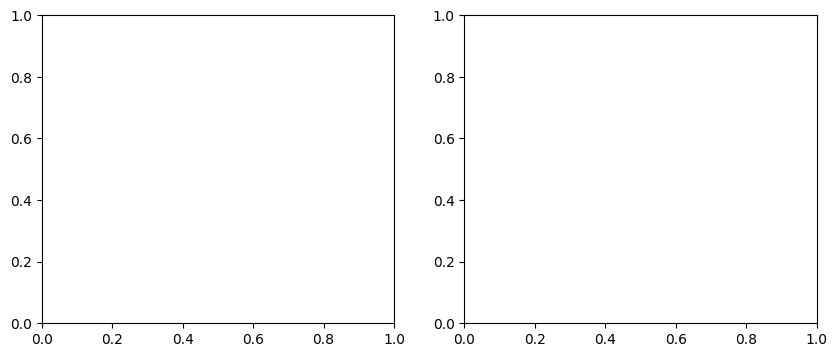

In [30]:
###################################################################################################################
#
# plot volatility clustering of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(torch.abs(OD_log_delta).detach().cpu().numpy(), ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Absolute Log-Returns')
axes[0].grid()

tsaplots.plot_acf(torch.abs(fake_original).detach().cpu().numpy(), ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Absolute Log-Returns (Generated)')
axes[1].grid()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

In [31]:
###################################################################################################################
#
# plot leverage effect of original log-returns on the left and the generated on the right
#
###################################################################################################################
# compute leverage effect for maximum lags = 18
leverage_original = []

for lag in range(1, 19):

    # slice the tensors to get the appropriate lagged sequences
    r_t = OD_log_delta[:-lag].detach().cpu().numpy()

    squared_lag_r = torch.square(torch.abs(OD_log_delta[lag:])).detach().cpu().numpy()
    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    leverage_original.append(correlation_matrix[0, 1])

leverage_generated = []

for lag in range(1, 19):

    # slice the tensors to get the appropriate lagged sequences
    r_t = fake_original[:-lag].detach().cpu().numpy()

    squared_lag_r = torch.square(torch.abs(fake_original[lag:])).detach().cpu().numpy()

    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    leverage_generated.append(correlation_matrix[0, 1])

axes[0].plot(leverage_original)
axes[0].set_xlabel('Lags')
axes[0].set_title('Original Leverage Effect')
axes[0].grid()
axes[1].plot(leverage_generated)
axes[1].set_xlabel('Lags')
axes[1].set_title('Generated Leverage Effect')
axes[1].grid()



In [32]:
df = pd.DataFrame(OD_log_delta.detach().cpu().numpy())

# Save the DataFrame to a CSV file
csv_filename = 'OD_log_delta.csv'
df.to_csv(csv_filename, index=False)

df = pd.DataFrame(fake_original.detach().cpu().numpy())

# Save the DataFrame to a CSV file
csv_filename = 'fake_orignial_lucy_log_returns.csv'
df.to_csv(csv_filename, index=False)

# Save the DataFrame to a CSV file
csv_filename = 'real.csv'
real_data.to_csv(csv_filename, index=False)

# Save the DataFrame to a CSV file
csv_filename = 'fake.csv'
fake_data.to_csv(csv_filename, index=False)

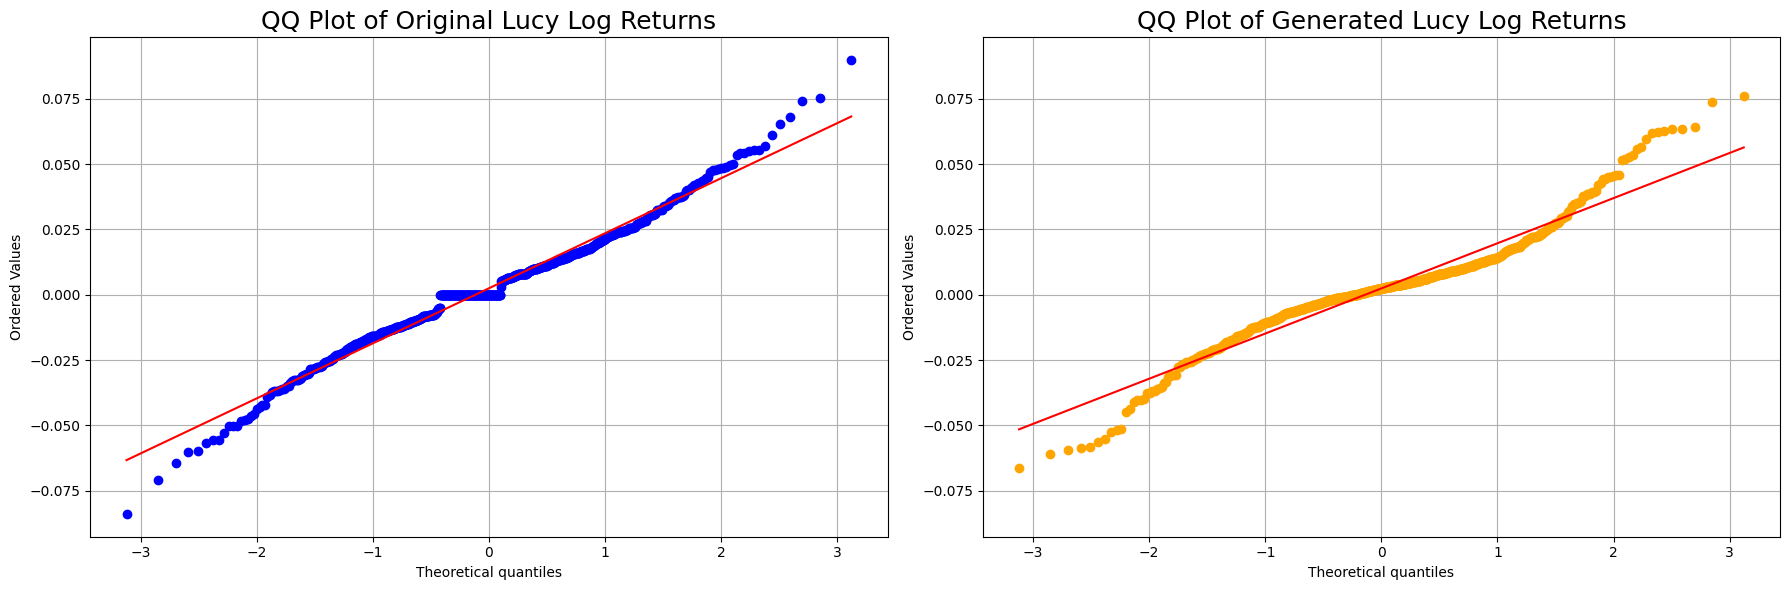

In [34]:
# Ensure both time series are of the same length for comparison
min_length = min(len(real_data), len(fake_data))
real_ts = real_data['Log_Return'][:min_length]
fake_ts = fake_data['Log_Return'][:min_length]

# Generate QQ plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# QQ plot for the original Lucy log returns
stats.probplot(real_ts, dist="norm", plot=ax1)
ax1.set_title('QQ Plot of Original Lucy Log Returns', fontsize= 18)
ax1.grid(True)

# QQ plot for the generated Lucy log returns
stats.probplot(fake_ts, dist="norm", plot=ax2)
ax2.get_lines()[0].set_color('orange')
ax2.set_title('QQ Plot of Generated Lucy Log Returns', fontsize= 18)
ax2.grid(True)

# Set the same scale for y axis
axes = plt.gca()
ylim1 = ax1.get_ylim()
ylim2 = ax2.get_ylim()
global_ylim = (min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
ax1.set_ylim(global_ylim)
ax2.set_ylim(global_ylim)

# Show the plots
plt.tight_layout()
plt.show()

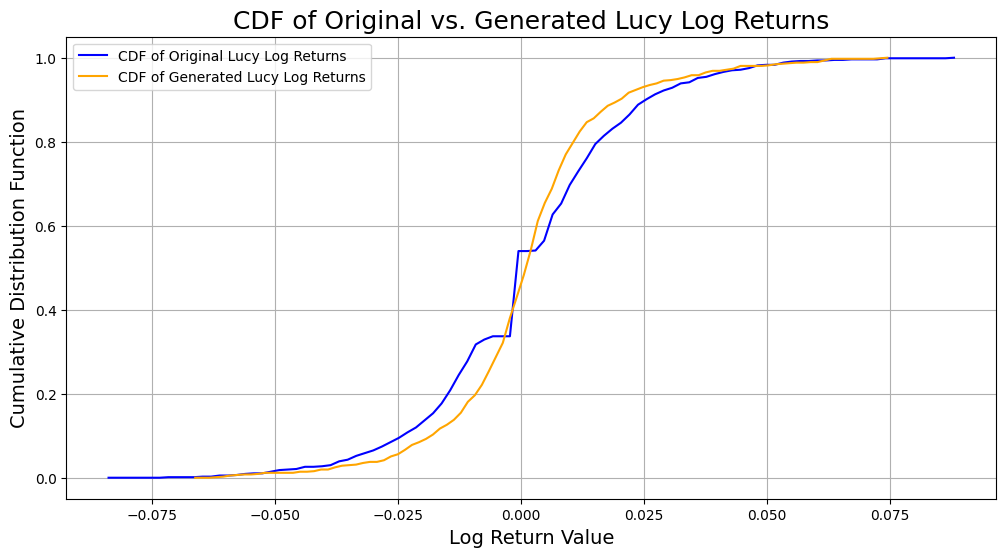

In [35]:
# Calculate the probability distribution of the real and fake time series
real_ts_values, real_ts_base = np.histogram(real_ts, bins=100, density=True)
fake_ts_values, fake_ts_base = np.histogram(fake_ts, bins=100, density=True)

# Compute the cumulative distribution functions for both time series
real_ts_cdf = np.cumsum(real_ts_values * np.diff(real_ts_base))
fake_ts_cdf = np.cumsum(fake_ts_values * np.diff(fake_ts_base))

# Plotting the probability distributions of the real and fake time series
plt.figure(figsize=(12, 6))
plt.plot(real_ts_base[:-1], real_ts_cdf, label='CDF of Original Lucy Log Returns', color='blue')
plt.plot(fake_ts_base[:-1], fake_ts_cdf, label='CDF of Generated Lucy Log Returns', color='orange')
plt.xlabel('Log Return Value',fontsize=14)
plt.ylabel('Cumulative Distribution Function',fontsize=14)
plt.title('CDF of Original vs. Generated Lucy Log Returns',fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

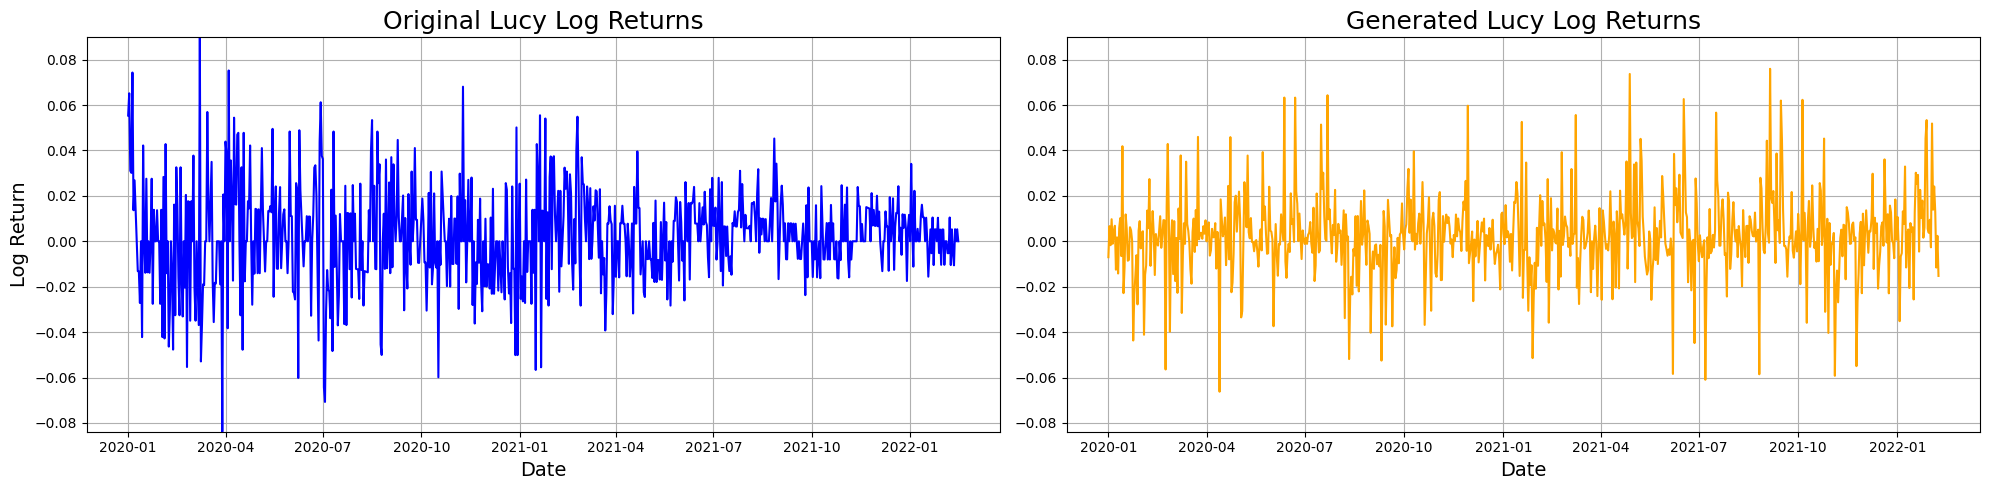

In [ ]:
# Plotting the time series with the same y-axis scale

# Convert 'Date' columns to datetime for proper plotting
real_data['DATE'] = pd.to_datetime(real_data['DATE'])
fake_data['DATE'] = pd.to_datetime(fake_data['DATE'])

# Determine the global min and max log return values for the y-axis scale
min_log_return = min(real_data['Log_Return'].min(), fake_data['Log_Return'].min())
max_log_return = max(real_data['Log_Return'].max(), fake_data['Log_Return'].max())

# Plot both time series with the same y-axis scale
plt.figure(figsize=(20, 5))

# Plotting the original 
plt.subplot(1, 2, 1)
plt.plot(real_data['DATE'], real_data['Log_Return'], color='blue')
plt.title('Original Lucy Log Returns',fontsize=18)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Log Return',fontsize=14)
plt.ylim(min_log_return, max_log_return)
plt.grid(True)

# Plotting the generated 
plt.subplot(1, 2, 2)
plt.plot(fake_data['DATE'], fake_data['Log_Return'], color='orange')
plt.title('Generated Lucy Log Returns',fontsize=18)
plt.xlabel('Date',fontsize=14)
plt.ylim(min_log_return, max_log_return)
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

/var/folders/x9/05_lgckd2f5fjpll2k2x6pkh0000gn/T/ipykernel_10247/16988689.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(real_ts, hist=False, kde=True,
/var/folders/x9/05_lgckd2f5fjpll2k2x6pkh0000gn/T/ipykernel_10247/16988689.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

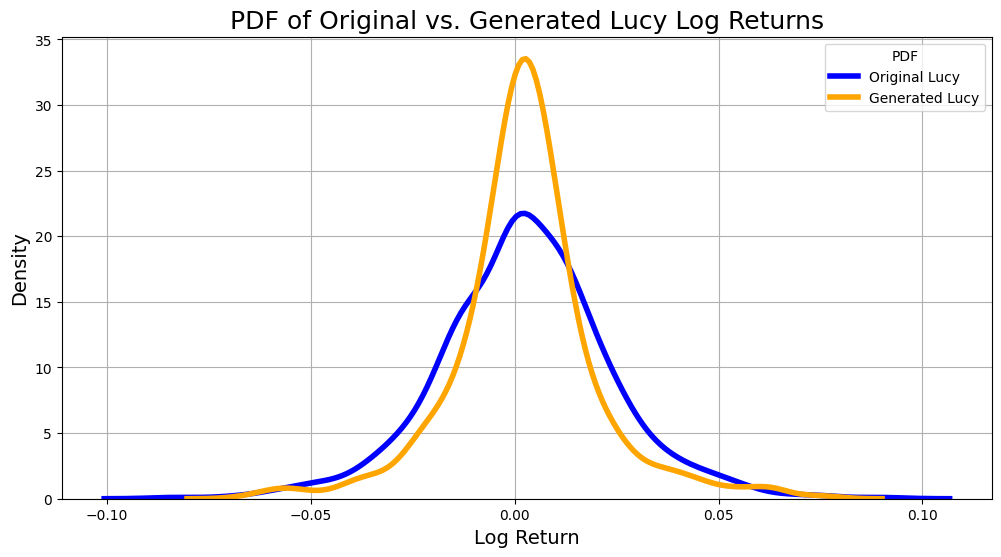

In [ ]:
# We will use seaborn's distplot to plot the PDFs of the real and fake data
plt.figure(figsize=(12, 6))

# Plotting the PDF of the original 
sns.distplot(real_ts, hist=False, kde=True,
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             label='Original Lucy')

# Plotting the PDF of the generated 
sns.distplot(fake_ts, hist=False, kde=True,
             bins=100, color = 'orange',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             label='Generated Lucy')

# Plot formatting
plt.legend(prop={'size': 10}, title = 'PDF')
plt.title('PDF of Original vs. Generated Lucy Log Returns', fontsize = 18)
plt.xlabel('Log Return', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.grid(True)

# Show the plot
plt.show()

In [38]:
# Calculate the Earth Mover's distance (also known as Wasserstein distance) between the two distributions
emd_value = wasserstein_distance(real_ts, fake_ts)
emd_value

# Calculate the entropy of the two distributions
# First, we need to calculate the probability distributions (histograms) with the same bins for both time series
real_ts_prob, bins = np.histogram(real_ts, bins=100, density=True)
fake_ts_prob, _ = np.histogram(fake_ts, bins=bins, density=True)

# The histograms are used to approximate the probability distributions, we can now calculate the entropy
# Entropy of the real time series
entropy_real = entropy(real_ts_prob)
# Entropy of the generated time series
entropy_fake = entropy(fake_ts_prob)

entropy_real, entropy_fake

(3.4836587749465187, 3.5484189009097595)

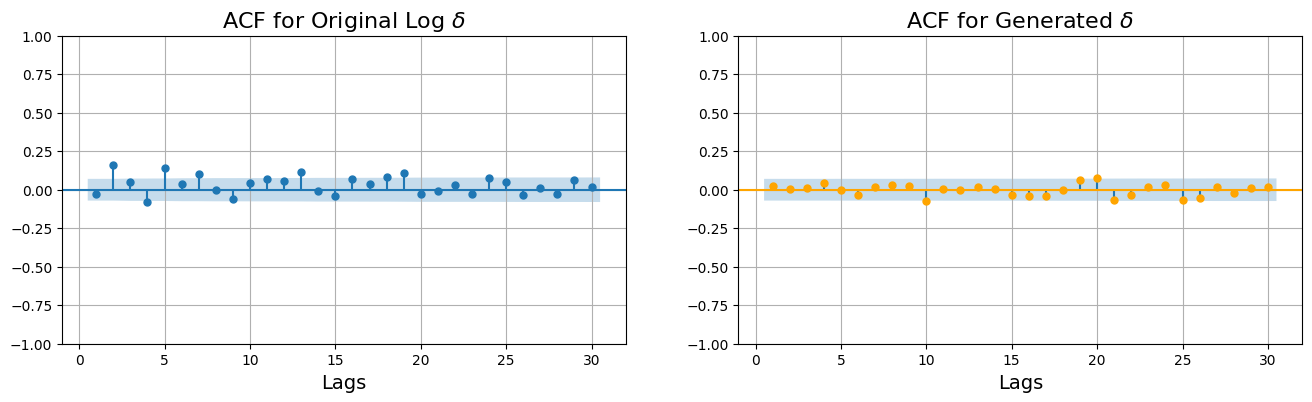

In [55]:
# Creating the ACF plots using the provided code structure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Plot autocorrelations of original log-returns on the left
tsaplots.plot_acf(real_ts, ax=axes[0], lags=30, zero=False)
axes[0].set_xlabel('Lags', fontsize = 14)
axes[0].set_title('ACF for Original Log $\delta$', fontsize = 16)
axes[0].grid()

# Plot autocorrelations of generated log-returns on the right
tsaplots.plot_acf(fake_ts, ax=axes[1], lags=30, zero=False, color='orange')
axes[1].set_xlabel('Lags', fontsize = 14)
axes[1].set_title('ACF for Generated $\delta$', fontsize = 16)
axes[1].grid()

plt.show()

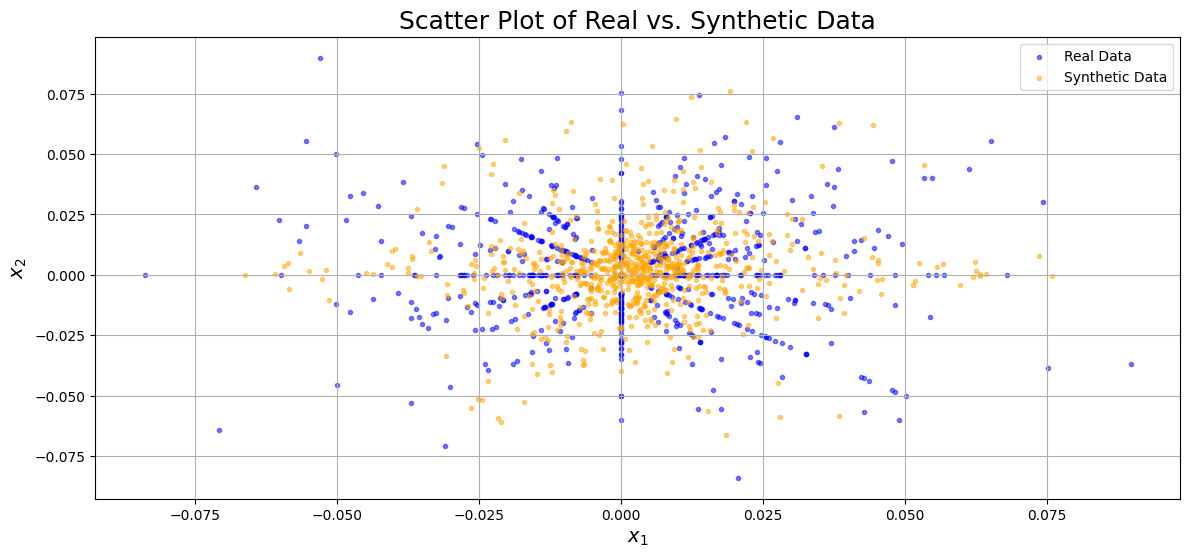

In [40]:
# To reproduce a similar scatter plot for the time series, we will plot the real data against the generated data.
# Since we only have one dimension (the log returns), we'll create a lagged version of the data to allow for a 2D scatter plot.

# Create a lagged version of the time series
real_ts_lagged = real_ts.shift(1).dropna()
fake_ts_lagged = fake_ts.shift(1).dropna()

# Take the same number of points from each to have a fair comparison
min_length = min(len(real_ts_lagged), len(fake_ts_lagged))
real_ts_plot = real_ts_lagged.iloc[:min_length]
fake_ts_plot = fake_ts_lagged.iloc[:min_length]
real_ts_current = real_ts.iloc[1:min_length+1]
fake_ts_current = fake_ts.iloc[1:min_length+1]

# Plot
plt.figure(figsize=(14, 6))
plt.scatter(real_ts_current, real_ts_plot, color='blue', alpha=0.5, label='Real Data', marker='.')
plt.scatter(fake_ts_current, fake_ts_plot, color='orange', alpha=0.5, label='Synthetic Data', marker='.')
plt.xlabel('$x_1$', fontsize = 14)
plt.ylabel('$x_2$', fontsize = 14)
plt.title('Scatter Plot of Real vs. Synthetic Data', fontsize = 18)
plt.legend()
plt.grid()
plt.show()

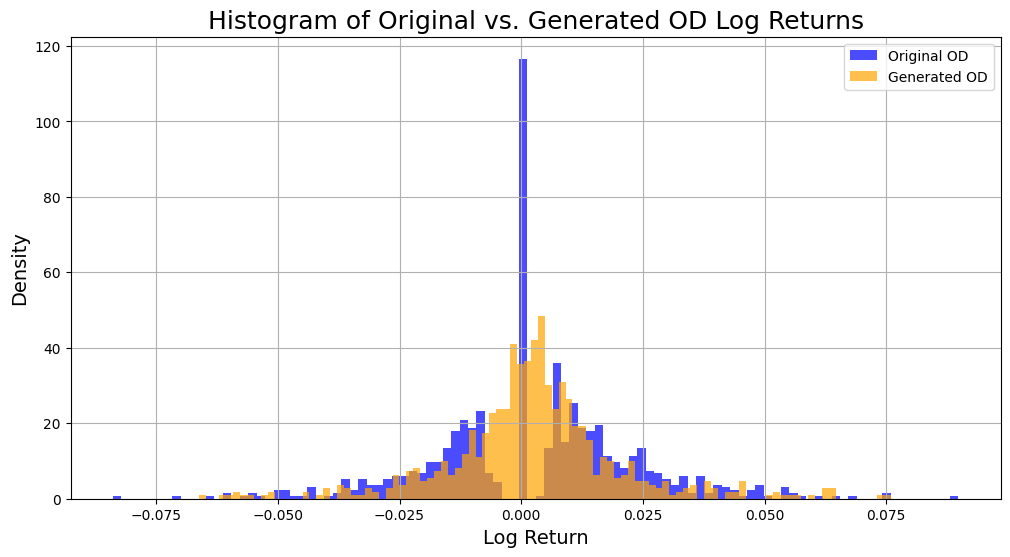

In [41]:
# Plotting the histograms of the two time series one over the other

plt.figure(figsize=(12, 6))

# Plotting the histogram for the original S&P 500 Log Returns
plt.hist(real_ts, bins=100, alpha=0.7, label='Original OD', color='blue', density = True)

# Plotting the histogram for the generated S&P 500 Log Returns
plt.hist(fake_ts, bins=100, alpha=0.7, label='Generated OD', color='orange', density = True)

plt.xlabel('Log Return', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.title('Histogram of Original vs. Generated OD Log Returns', fontsize = 18)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

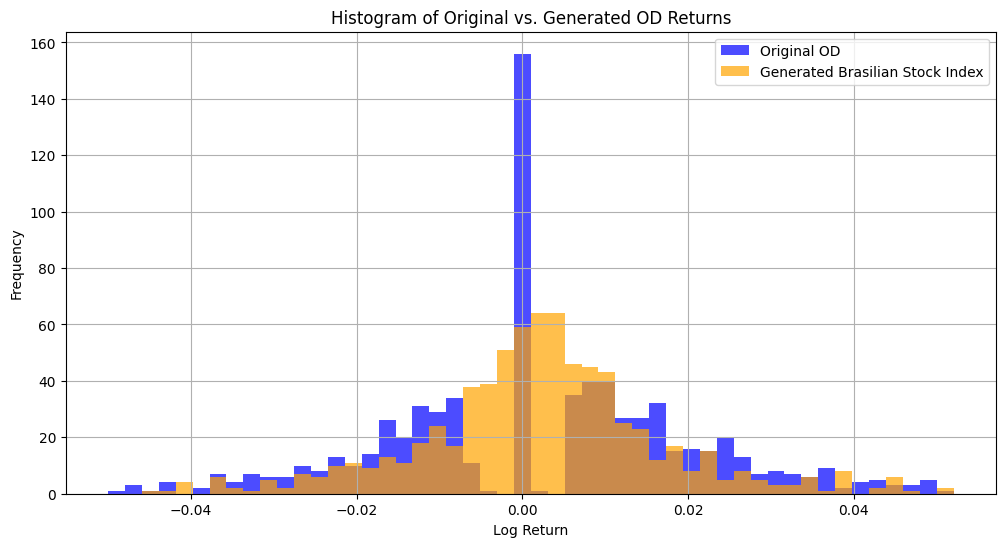

In [42]:
# Plotting the histograms of the two time series one over the other

plt.figure(figsize=(12, 6))
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
# Plotting the histogram for the original S&P 500 Log Returns
plt.hist(real_ts, bins=bin_edges, alpha=0.7, label='Original OD', color='blue')

# Plotting the histogram for the generated S&P 500 Log Returns
plt.hist(fake_ts, bins=bin_edges, alpha=0.7, label='Generated Brasilian Stock Index', color='orange')

plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.title('Histogram of Original vs. Generated OD Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [43]:
series1 = real_data['Log_Return'].to_numpy().reshape(-1,1)
series2 = fake_data['Log_Return'].to_numpy().reshape(-1,1)

dtw_distance, warping_path = fastdtw(series1,series2, dist=euclidean)
dtw_distance

11.93579124642457

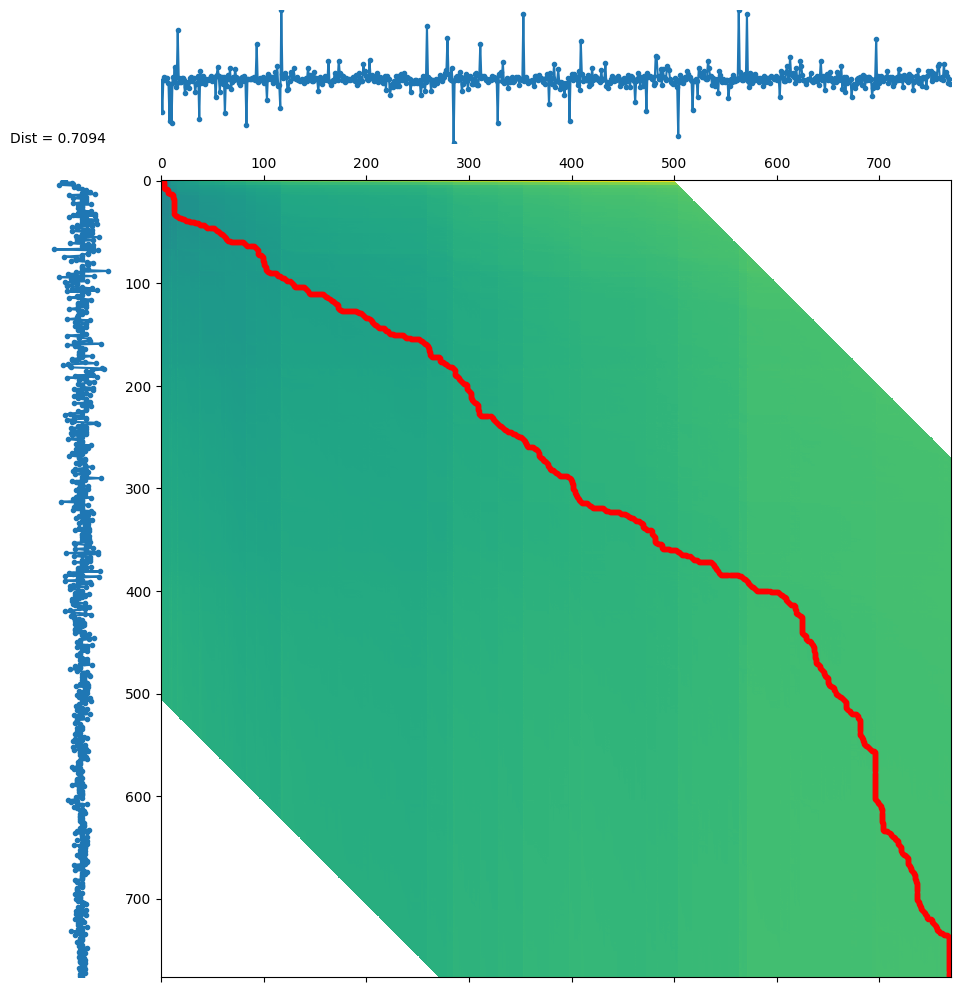

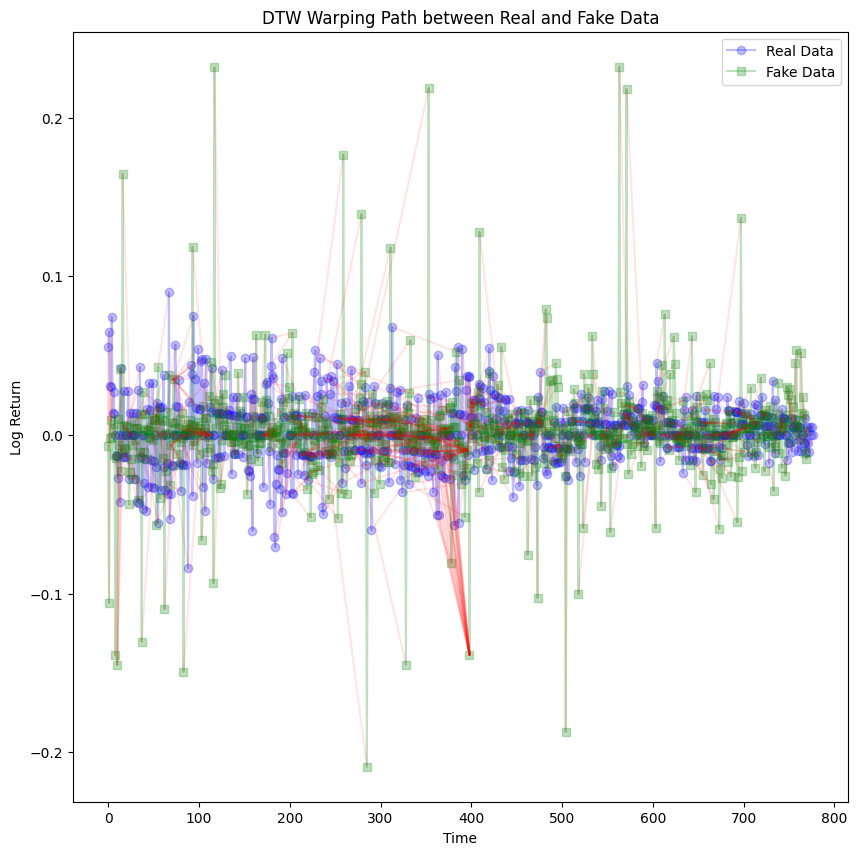

In [44]:
for idx in range(len(series2)):
    if random.random() < 0.05:
        series2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(series1, series2, window=500, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(series1, series2, paths, best_path)

# Re-attempt to plot the warping path correctly

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first series on the x-axis
ax.plot(series1, 'bo-', label='Real Data', alpha = 0.25)


# Plot the second series on the y-axis
ax.plot(series2, 'gs-', label='Fake Data', alpha = 0.25)

# Draw lines between the matched points in the warping path
for (i, j) in warping_path:
    ax.plot([i, j], [series1[i], series2[j]], 'r-', alpha=0.1)

# Labeling the plot
ax.set_xlabel('Time')
ax.set_ylabel('Log Return')
ax.set_title('DTW Warping Path between Real and Fake Data')
ax.legend()
plt.show()

In [45]:
d

0.709383638796459